In [24]:
import tensorflow as tf
from tensorflow.keras import layers, models
import sqlite3
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import lightgbm as lgb
from nba_api.stats.endpoints import leaguegamelog, playergamelogs, teamgamelogs
from time import sleep
import time
from filterpy.kalman import KalmanFilter
from typing import Dict, Tuple
from tqdm import tqdm

In [117]:
def load_player_data(connection, start_season, end_season):
    """Loads basic, advanced, and scoring boxscores 
    from sqlite db and merges them into one dataframe"""
    

    df_player = pd.read_sql("""SELECT b.*, E_OFF_RATING, E_DEF_RATING, E_NET_RATING, AST_PCT, AST_TOV, AST_RATIO, OREB_PCT, DREB_PCT, REB_PCT,
        EFG_PCT, TS_PCT, E_USG_PCT, E_PACE, POSS, PIE, PCT_FGA_2PT, PCT_FGA_3PT, PCT_PTS_2PT, PCT_PTS_2PT_MR, 
        PCT_PTS_3PT, PCT_AST_2PM, PCT_UAST_2PM, PCT_AST_3PM, PCT_UAST_3PM, 
        PCT_AST_FGM, PCT_UAST_FGM, contestedShots, contestedShots2pt, contestedShots3pt, deflections, chargesDrawn, screenAssists,
        screenAssistPoints, looseBallsRecoveredOffensive, looseBallsRecoveredDefensive, looseBallsRecoveredTotal, offensiveBoxOuts,
        defensiveBoxOuts, boxOutPlayerTeamRebounds, boxOutPlayerRebounds, boxOuts, DIST, ORBC, DRBC, RBC, TCHS, SAST, FTAST, PASS,
        CFGM, CFGA, CFG_PCT, UFGM, UFGA, UFG_PCT, DFGM, DFGA, DFG_PCT, PTS_OFF_TOV, PTS_2ND_CHANCE, PTS_FB, PTS_PAINT
        FROM player_basic_stats b 
        LEFT JOIN player_advanced_stats adv ON b.PLAYER_ID = adv.PLAYER_ID AND b.GAME_ID = adv.GAME_ID
        LEFT JOIN player_scoring_stats sco ON b.PLAYER_ID = sco.PLAYER_ID AND b.GAME_ID = sco.GAME_ID 
        LEFT JOIN player_hustle_stats hust ON b.PLAYER_ID = hust.personId AND b.GAME_ID = hust.gameId
        LEFT JOIN player_track_stats track ON b.PLAYER_ID = track.PLAYER_ID AND b.GAME_ID = track.GAME_ID
        LEFT JOIN player_miscellaneous_stats misc ON b.PLAYER_ID = misc.PLAYER_ID AND b.GAME_ID = misc.GAME_ID

                                """, connection)
    
    df_team = pd.read_sql("""SELECT b.*, E_OFF_RATING, E_DEF_RATING, E_NET_RATING, AST_PCT, AST_TOV, AST_RATIO, OREB_PCT, DREB_PCT, REB_PCT,
        E_TM_TOV_PCT, TM_TOV_PCT, EFG_PCT, TS_PCT, E_USG_PCT, E_PACE, POSS, PIE, PCT_FGA_2PT, PCT_FGA_3PT, PCT_PTS_2PT, PCT_PTS_2PT_MR, 
        PCT_PTS_3PT, PCT_AST_2PM, PCT_UAST_2PM, PCT_AST_3PM, PCT_UAST_3PM, 
        PCT_AST_FGM, PCT_UAST_FGM, contestedShots, contestedShots2pt, contestedShots3pt, deflections, chargesDrawn, screenAssists,
        screenAssistPoints, looseBallsRecoveredOffensive, looseBallsRecoveredDefensive, looseBallsRecoveredTotal, offensiveBoxOuts,
        defensiveBoxOuts, boxOutPlayerTeamRebounds, boxOutPlayerRebounds, boxOuts, DIST, ORBC, DRBC, RBC, TCHS, SAST, FTAST, PASS,
        CFGM, CFGA, CFG_PCT, UFGM, UFGA, UFG_PCT, DFGM, DFGA, DFG_PCT, PTS_OFF_TOV, PTS_2ND_CHANCE, PTS_FB, PTS_PAINT
        FROM team_basic_stats b 
        LEFT JOIN team_advanced_stats adv ON b.team_ID = adv.team_ID AND b.GAME_ID = adv.GAME_ID
        LEFT JOIN team_scoring_stats sco ON b.team_ID = sco.team_ID AND b.GAME_ID = sco.GAME_ID 
        LEFT JOIN team_hustle_stats hust ON b.team_ID = hust.teamId AND b.GAME_ID = hust.gameId
        LEFT JOIN team_track_stats track ON b.team_ID = track.team_ID AND b.GAME_ID = track.GAME_ID
        LEFT JOIN team_miscellaneous_stats misc ON b.team_ID = misc.team_ID AND b.GAME_ID = misc.GAME_ID
                                """, connection)
    
    df_player = df_player.add_suffix('_player')
    df_team = df_team.add_suffix('_team')
    
    df_merged = pd.merge(df_player, df_team, how='left', left_on=['GAME_ID_player', 'TEAM_ID_player'], right_on=['GAME_ID_team', 'TEAM_ID_team'])
    
    df_merged = df_merged.loc[df_merged['SEASON_YEAR_player'].between(start_season, end_season)]
    
    rename_dic = {'SEASON_YEAR_player': 'SEASON_YEAR'
                ,'PLAYER_ID_player': 'PLAYER_ID'
                ,'PLAYER_NAME_player': 'PLAYER_NAME'
                ,'NICKNAME_player': 'NICKNAME'
                ,'TEAM_ID_player': 'TEAM_ID'
                ,'TEAM_ABBREVIATION_player': 'TEAM_ABBREVIATION' 
                ,'TEAM_NAME_player': 'TEAM_NAME'
                ,'GAME_ID_player': 'GAME_ID'
                ,'GAME_DATE_player': 'GAME_DATE' 
                ,'MATCHUP_player': 'MATCHUP'
                ,'WL_player': 'WL'}
    
    df_merged = df_merged.rename(columns = rename_dic)
    drop_cols = ['SEASON_ID_team'
        ,'TEAM_ID_team'
        ,'TEAM_ABBREVIATION_team'
        ,'TEAM_NAME_team'
        ,'GAME_ID_team'
        ,'GAME_DATE_team'
        ,'MATCHUP_team'
        , 'WL_team'] + [x for x in df.columns if 'RANK' in x]
    
    df_merged = df_merged.drop(columns=drop_cols)        
    
    return df_merged


start_season = '2016-17'
end_season = '2023-24'

connection = sqlite3.connect('nba_stats.db')
df = load_player_data(connection, start_season, end_season)
connection.close()

In [131]:
df.columns.tolist()

['SEASON_YEAR',
 'PLAYER_ID',
 'PLAYER_NAME',
 'NICKNAME',
 'TEAM_ID',
 'TEAM_ABBREVIATION',
 'TEAM_NAME',
 'GAME_ID',
 'GAME_DATE',
 'MATCHUP',
 'WL',
 'MIN_player',
 'FGM_player',
 'FGA_player',
 'FG_PCT_player',
 'FG3M_player',
 'FG3A_player',
 'FG3_PCT_player',
 'FTM_player',
 'FTA_player',
 'FT_PCT_player',
 'OREB_player',
 'DREB_player',
 'REB_player',
 'AST_player',
 'TOV_player',
 'STL_player',
 'BLK_player',
 'BLKA_player',
 'PF_player',
 'PFD_player',
 'PTS_player',
 'PLUS_MINUS_player',
 'NBA_FANTASY_PTS_player',
 'DD2_player',
 'TD3_player',
 'WNBA_FANTASY_PTS_player',
 'AVAILABLE_FLAG_player',
 'MIN_SEC_player',
 'E_OFF_RATING_player',
 'E_DEF_RATING_player',
 'E_NET_RATING_player',
 'AST_PCT_player',
 'AST_TOV_player',
 'AST_RATIO_player',
 'OREB_PCT_player',
 'DREB_PCT_player',
 'REB_PCT_player',
 'EFG_PCT_player',
 'TS_PCT_player',
 'E_USG_PCT_player',
 'E_PACE_player',
 'POSS_player',
 'PIE_player',
 'PCT_FGA_2PT_player',
 'PCT_FGA_3PT_player',
 'PCT_PTS_2PT_player',
 

In [ ]:
clean_betting_df = clean_betting_data(betting_data)

In [102]:
conn = sqlite3.connect('nba_stats.db')

df_basic_team = pd.read_sql("""SELECT * FROM team_basic_stats""", conn)
df_basic_player = pd.read_sql("""SELECT * FROM player_basic_stats""", conn)

df_track_player = pd.read_sql("""SELECT * FROM player_track_stats""", conn)
df_adv_team = pd.read_sql("""SELECT * FROM team_advanced_stats""", conn)
df_hustle_team = pd.read_sql("""SELECT * FROM team_hustle_stats""", conn)
df_track_team = pd.read_sql("""SELECT * FROM team_track_stats""", conn)
df_misc_team = pd.read_sql("""SELECT * FROM team_miscellaneous_stats""", conn)
df_usage_team = pd.read_sql("""SELECT * FROM team_usage_stats""", conn)

conn.close()




In [126]:
class PlayerKalmanFilter:
    def __init__(self, initial_state, initial_estimate_error, process_variance, measurement_variance):
        self.state_estimate = initial_state
        self.estimate_error = initial_estimate_error
        self.process_variance = process_variance
        self.measurement_variance = measurement_variance

    def predict(self):
        predicted_state = self.state_estimate
        predicted_estimate_error = self.estimate_error + self.process_variance
        return predicted_state, predicted_estimate_error

    def update(self, measurement):
        predicted_state, predicted_estimate_error = self.predict()
        kalman_gain = predicted_estimate_error / (predicted_estimate_error + self.measurement_variance)
        self.state_estimate = predicted_state + kalman_gain * (measurement - predicted_state)
        self.estimate_error = (1 - kalman_gain) * predicted_estimate_error

    def predict_next_game(self):
        predicted_state, _ = self.predict()
        return predicted_state

def predict_player_points_kalman(player_data, initial_state=10, initial_error=10, process_variance=1, measurement_variance=10):
    kf = PlayerKalmanFilter(initial_state, initial_error, process_variance, measurement_variance)
    predictions = []
    for pts in player_data['PTS_player']:
        prediction = kf.predict_next_game()
        predictions.append(prediction)
        kf.update(pts)
    return predictions

def predict_ewa(df: pd.DataFrame, span: int) -> pd.DataFrame:
    df = df.sort_values(['PLAYER_ID', 'GAME_DATE'])
    
    # Calculate EWA for all players at once
    df['PREDICTED_POINTS'] = df.groupby('PLAYER_ID')['PTS_player'].transform(lambda x: x.ewm(span=span, adjust=False).mean().shift(1))
    
    return df[['PLAYER_ID', 'GAME_DATE', 'PREDICTED_POINTS']]

def calculate_metrics(actual, predicted):
    mae = np.mean(np.abs(np.array(actual) - np.array(predicted)))
    mse = np.mean((np.array(actual) - np.array(predicted))**2)
    return mae, mse

def analyze_all_players(df, min_games=1, ewa_span=20):
    results = []
    
    # Calculate EWA predictions for all players at once
    ewa_predictions = predict_ewa(df, span=ewa_span)
    df = df.merge(ewa_predictions, on=['PLAYER_ID', 'GAME_DATE'], how='left')
    
    unique_players = df['PLAYER_ID'].unique()
    
    for player_id in tqdm(unique_players, desc="Analyzing players"):
        player_data = df[df['PLAYER_ID'] == player_id].sort_values('GAME_DATE')
        
        if len(player_data) < min_games:
            continue
        
        actual_points = player_data['PTS_player'].tolist()
        
        kalman_predictions = predict_player_points_kalman(player_data)
        ewa_predictions = player_data['PREDICTED_POINTS'].dropna().tolist()
        
        # Ensure all lists have the same length for fair comparison
        min_length = min(len(kalman_predictions), len(ewa_predictions), len(actual_points) - 1)
        kalman_mae, kalman_mse = calculate_metrics(actual_points[1:min_length+1], kalman_predictions[:min_length])
        ewa_mae, ewa_mse = calculate_metrics(actual_points[1:min_length+1], ewa_predictions[:min_length])
        
        results.append({
            'PLAYER_ID': player_id,
            'PLAYER_NAME': player_data['PLAYER_NAME'].iloc[0],
            'NUM_GAMES': len(player_data),
            'KALMAN_MAE': kalman_mae,
            'KALMAN_MSE': kalman_mse,
            'EWA_MAE': ewa_mae,
            'EWA_MSE': ewa_mse
        })
    
    return pd.DataFrame(results)


results_df = analyze_all_players(df, min_games=1, ewa_span=20)


Analyzing players:  40%|████      | 509/1271 [00:02<00:02, 339.29it/s]c:\Users\Jordan Nishimura\nba_model_using_player_embeddings\.venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Jordan Nishimura\nba_model_using_player_embeddings\.venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Analyzing players: 100%|██████████| 1271/1271 [00:03<00:00, 348.52it/s]


In [127]:
results_df

,PLAYER_ID,PLAYER_NAME,NUM_GAMES,KALMAN_MAE,KALMAN_MSE,EWA_MAE,EWA_MSE
0,1626171,Bobby Portis,592,5.293932,44.794038,4.967563,40.051057
1,1627758,Ron Baker,96,2.939701,12.592623,2.829500,11.259624
2,201980,Danny Green,520,4.432019,30.077006,4.137259,27.186359
3,2207,Joe Johnson,153,4.530043,31.322919,5.199299,43.097513
4,202714,Shelvin Mack,190,4.271512,27.494627,4.197358,25.651784
...,...,...,...,...,...,...,...
1266,1630259,Jordan Ford,6,3.634324,19.841938,2.502786,9.573886
1267,1630196,Filip Petrusev,3,5.880952,51.552154,1.500000,4.500000
1268,1641806,Markquis Nowell,1,NaN,NaN,NaN,NaN
1269,1630608,Malcolm Cazalon,1,NaN,NaN,NaN,NaN


Analyzing players: 100%|██████████| 1271/1271 [00:03<00:00, 342.42it/s]


          PLAYER_ID    NUM_GAMES   KALMAN_MAE   KALMAN_MSE      EWA_MAE  \
count  1.088000e+03  1088.000000  1088.000000  1088.000000  1088.000000   
mean   1.136759e+06   198.471507    13.568233   217.640132     2.610703   
std    6.914681e+05   176.837196     3.486276    83.302361     0.885788   
min    1.713000e+03    10.000000     5.430380    49.669477     0.233407   
25%    2.034705e+05    46.750000    11.214286   155.516855     2.018834   
50%    1.628396e+06   141.000000    14.123543   222.014197     2.598718   
75%    1.630183e+06   314.500000    16.349359   284.039130     3.163284   
max    1.641998e+06   675.000000    19.769231   391.153846     5.224711   

           EWA_MSE  
count  1088.000000  
mean     12.674675  
std       7.676695  
min       0.184753  
25%       7.306041  
50%      11.444408  
75%      16.381971  
max      45.142588  


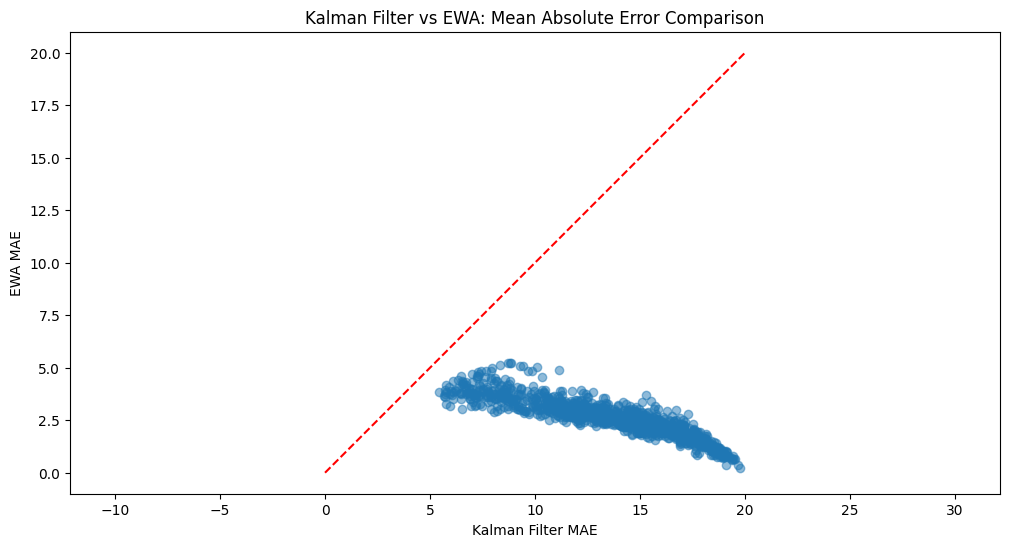

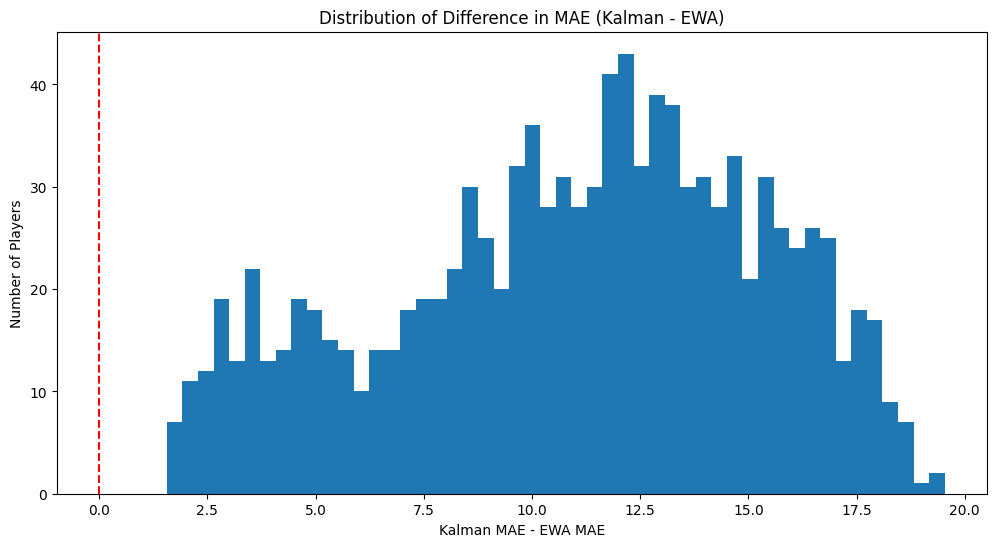


Players where Kalman filter significantly outperforms EWA:
Empty DataFrame
Columns: [PLAYER_NAME, KALMAN_MAE, EWA_MAE]
Index: []

Players where EWA significantly outperforms Kalman filter:
              PLAYER_NAME  KALMAN_MAE   EWA_MAE
0            Bobby Portis    8.839255  3.479072
1               Ron Baker   16.842105  1.903651
2             Danny Green   12.154143  2.940995
3             Joe Johnson   12.190789  3.185054
4            Shelvin Mack   12.687831  2.752628
...                   ...         ...       ...
1083      Bilal Coulibaly   11.693548  2.677734
1084      Julian Phillips   17.717949  1.560768
1085       Ausar Thompson   11.193548  2.656761
1086  Jalen Hood-Schifino   18.300000  1.156168
1087        Nathan Mensah   18.791667  0.768352

[1088 rows x 3 columns]


In [125]:
def predict_kalman(df: pd.DataFrame, initial_state=20, initial_error=5, process_variance=1, measurement_variance=10) -> pd.DataFrame:
    df = df.sort_values(['PLAYER_ID', 'GAME_DATE'])
    
    # Initialize state and error for each player
    df['state'] = initial_state
    df['error'] = initial_error
    
    # Prediction step
    df['predicted_state'] = df.groupby('PLAYER_ID')['state'].shift(1).fillna(initial_state)
    df['predicted_error'] = df.groupby('PLAYER_ID')['error'].shift(1).fillna(initial_error) + process_variance
    
    # Kalman gain
    df['kalman_gain'] = df['predicted_error'] / (df['predicted_error'] + measurement_variance)
    
    # Update step
    df['state'] = df['predicted_state'] + df['kalman_gain'] * (df['PTS_player'] - df['predicted_state'])
    df['error'] = (1 - df['kalman_gain']) * df['predicted_error']
    
    # Prepare output
    df['KALMAN_PREDICTED_POINTS'] = df.groupby('PLAYER_ID')['predicted_state'].shift()
    
    return df[['PLAYER_ID', 'GAME_DATE', 'KALMAN_PREDICTED_POINTS']]

def predict_ewa(df: pd.DataFrame, span: int) -> pd.DataFrame:
    df = df.sort_values(['PLAYER_ID', 'GAME_DATE'])
    
    # Calculate EWA for all players at once
    df['EWA_PREDICTED_POINTS'] = df.groupby('PLAYER_ID')['PTS_player'].transform(lambda x: x.ewm(span=span, adjust=False).mean())
    
    # Shift predictions to align with next game
    df['EWA_PREDICTED_POINTS'] = df.groupby('PLAYER_ID')['EWA_PREDICTED_POINTS'].shift()
    
    return df[['PLAYER_ID', 'GAME_DATE', 'EWA_PREDICTED_POINTS']]

def calculate_metrics(actual, predicted):
    mae = np.mean(np.abs(np.array(actual) - np.array(predicted)))
    mse = np.mean((np.array(actual) - np.array(predicted))**2)
    return mae, mse

def analyze_all_players(df, min_games=10, ewa_span=5):
    # Calculate predictions for all players at once
    kalman_predictions = predict_kalman(df)
    ewa_predictions = predict_ewa(df, span=ewa_span)
    
    # Merge predictions with original dataframe
    df = df.merge(kalman_predictions, on=['PLAYER_ID', 'GAME_DATE'], how='left')
    df = df.merge(ewa_predictions, on=['PLAYER_ID', 'GAME_DATE'], how='left')
    
    results = []
    unique_players = df['PLAYER_ID'].unique()
    
    for player_id in tqdm(unique_players, desc="Analyzing players"):
        player_data = df[df['PLAYER_ID'] == player_id].sort_values('GAME_DATE')
        
        if len(player_data) < min_games:
            continue
        
        actual_points = player_data['PTS_player'].dropna().tolist()
        kalman_predictions = player_data['KALMAN_PREDICTED_POINTS'].dropna().tolist()
        ewa_predictions = player_data['EWA_PREDICTED_POINTS'].dropna().tolist()
        
        # Ensure all lists have the same length for fair comparison
        min_length = min(len(kalman_predictions), len(ewa_predictions), len(actual_points) - 1)
        kalman_mae, kalman_mse = calculate_metrics(actual_points[:min_length], kalman_predictions[:min_length])
        ewa_mae, ewa_mse = calculate_metrics(actual_points[:min_length], ewa_predictions[:min_length])
        
        results.append({
            'PLAYER_ID': player_id,
            'PLAYER_NAME': player_data['PLAYER_NAME'].iloc[0],
            'NUM_GAMES': len(player_data),
            'KALMAN_MAE': kalman_mae,
            'KALMAN_MSE': kalman_mse,
            'EWA_MAE': ewa_mae,
            'EWA_MSE': ewa_mse
        })
    
    return pd.DataFrame(results)

def plot_results(results_df):
    plt.figure(figsize=(12, 6))
    plt.scatter(results_df['KALMAN_MAE'], results_df['EWA_MAE'], alpha=0.5)
    plt.plot([0, 20], [0, 20], 'r--')  # diagonal line
    plt.xlabel('Kalman Filter MAE')
    plt.ylabel('EWA MAE')
    plt.title('Kalman Filter vs EWA: Mean Absolute Error Comparison')
    plt.axis('equal')
    plt.show()

    plt.figure(figsize=(12, 6))
    mae_diff = results_df['KALMAN_MAE'] - results_df['EWA_MAE']
    plt.hist(mae_diff, bins=50)
    plt.xlabel('Kalman MAE - EWA MAE')
    plt.ylabel('Number of Players')
    plt.title('Distribution of Difference in MAE (Kalman - EWA)')
    plt.axvline(x=0, color='r', linestyle='--')
    plt.show()

# Example usage
results_df = analyze_all_players(df, min_games=10, ewa_span=5)

print(results_df.describe())

plot_results(results_df)

# Find players where one method significantly outperforms the other
threshold = 1.0  # MAE difference threshold
kalman_better = results_df[results_df['EWA_MAE'] - results_df['KALMAN_MAE'] > threshold]
ewa_better = results_df[results_df['KALMAN_MAE'] - results_df['EWA_MAE'] > threshold]

print("\nPlayers where Kalman filter significantly outperforms EWA:")
print(kalman_better[['PLAYER_NAME', 'KALMAN_MAE', 'EWA_MAE']])

print("\nPlayers where EWA significantly outperforms Kalman filter:")
print(ewa_better[['PLAYER_NAME', 'KALMAN_MAE', 'EWA_MAE']])

,PLAYER_ID,PLAYER_NAME,NUM_GAMES,KALMAN_MAE,KALMAN_MSE,EWA_MAE,EWA_MSE
0,1626171,Bobby Portis,592,5.326891,45.328807,4.967563,40.051057
1,1627758,Ron Baker,96,3.186940,17.496229,2.829500,11.259624
2,201980,Danny Green,520,4.462392,30.667596,4.137259,27.186359
3,2207,Joe Johnson,153,4.646672,33.149885,5.199299,43.097513
4,202714,Shelvin Mack,190,4.375789,28.691773,4.197358,25.651784
...,...,...,...,...,...,...,...
1266,1630259,Jordan Ford,6,8.633632,105.235598,2.502786,9.573886
1267,1630196,Filip Petrusev,3,14.750000,245.125000,1.500000,4.500000
1268,1641806,Markquis Nowell,1,NaN,NaN,NaN,NaN
1269,1630608,Malcolm Cazalon,1,NaN,NaN,NaN,NaN


In [31]:
def initialize_kalman_filter() -> KalmanFilter:
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([0., 0.])  # [points, points_velocity]
    kf.F = np.array([[1., 1.], [0., 1.]])  # state transition matrix
    kf.H = np.array([[1., 0.]])  # measurement function
    kf.P *= 1000.  # covariance matrix
    kf.R = 5  # measurement noise
    kf.Q = np.eye(2) * 0.01  # process noise
    return kf

def predict_points(df: pd.DataFrame) -> pd.DataFrame:
    # Sort the dataframe by player and date
    df = df.sort_values(['PLAYER_ID', 'GAME_DATE'])
    
    player_filters: Dict[int, Tuple[KalmanFilter, float]] = {}
    predictions = []

    for _, row in df.iterrows():
        player_id = row['PLAYER_ID']
        points = row['PTS']
        
        if player_id not in player_filters:
            kf = initialize_kalman_filter()
            player_filters[player_id] = (kf, points)
        else:
            kf, _ = player_filters[player_id]
        
        # Predict
        kf.predict()
        predicted_points = kf.x[0]
        
        # Update
        kf.update(points)
        
        # Store the prediction and updated estimate
        predictions.append({
            'PLAYER_ID': player_id,
            'GAME_DATE': row['GAME_DATE'],
            'ACTUAL_POINTS': points,
            'PREDICTED_POINTS': predicted_points,
            'UPDATED_ESTIMATE': kf.x[0]
        })
        
        # Update the player's filter
        player_filters[player_id] = (kf, kf.x[0])
    
    return pd.DataFrame(predictions)

In [32]:

# Assuming 'df' is your input dataframe
results = predict_points(df)

# Merge the results back to the original dataframe
df_with_predictions = df.merge(results[['PLAYER_ID', 'GAME_DATE', 'PREDICTED_POINTS']], 
                               on=['PLAYER_ID', 'GAME_DATE'], 
                               how='left')

# Calculate prediction error
df_with_predictions['PREDICTION_ERROR'] = df_with_predictions['PTS'] - df_with_predictions['PREDICTED_POINTS']

# Print some summary statistics
print(df_with_predictions['PREDICTION_ERROR'].describe())

count    216727.000000
mean         -0.002890
std           6.417663
min         -46.176997
25%          -3.934198
50%          -0.389245
75%           3.634291
max          50.754738
Name: PREDICTION_ERROR, dtype: float64


In [34]:
df_with_predictions.loc[df_with_predictions['PLAYER_NAME'] == 'Stephen Curry', ['PLAYER_NAME', 'GAME_DATE', 'PTS', 'PREDICTED_POINTS', 'PREDICTION_ERROR']].head(20)

,PLAYER_NAME,GAME_DATE,PTS,PREDICTED_POINTS,PREDICTION_ERROR
29725,Stephen Curry,2016-10-25T00:00:00,26,0.000000,26.000000
29726,Stephen Curry,2016-10-28T00:00:00,23,38.902679,-15.902679
29727,Stephen Curry,2016-10-30T00:00:00,28,20.603649,7.396351
29728,Stephen Curry,2016-11-01T00:00:00,28,27.858772,0.141228
29729,Stephen Curry,2016-11-03T00:00:00,21,29.115292,-8.115292
29730,Stephen Curry,2016-11-04T00:00:00,13,23.775386,-10.775386
29731,Stephen Curry,2016-11-07T00:00:00,46,16.088541,29.911459
29732,Stephen Curry,2016-11-09T00:00:00,24,31.335522,-7.335522
29733,Stephen Curry,2016-11-10T00:00:00,33,28.859232,4.140768
29734,Stephen Curry,2016-11-13T00:00:00,30,31.376708,-1.376708


In [35]:
np.mean(np.abs(df_with_predictions['PREDICTION_ERROR']))

4.8602982551868195

In [25]:

def initialize_kalman_filter() -> KalmanFilter:
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([0., 0.])  # [points, points_velocity]
    kf.F = np.array([[1., 1.], [0., 1.]])  # state transition matrix
    kf.H = np.array([[1., 0.]])  # measurement function
    kf.P *= 1000.  # covariance matrix
    kf.R = 5  # measurement noise
    kf.Q = np.eye(2) * 0.01  # process noise
    return kf

def predict_next_game_points(df: pd.DataFrame) -> pd.DataFrame:
    # Sort the dataframe by player and date
    df = df.sort_values(['PLAYER_ID', 'GAME_DATE'])
    
    player_filters: Dict[int, Tuple[KalmanFilter, float]] = {}
    predictions = []

    for player_id, player_df in tqdm(df.groupby('PLAYER_ID')):
        
        kf = initialize_kalman_filter()
        
        for i, row in player_df.iterrows():
            points = row['PTS']
            game_date = row['GAME_DATE']
            
            # print(f"  Game {i+1}: Date {game_date}, Points {points}")
            
            # Predict for the current game
            kf.predict()
            predicted_points = kf.x[0]
            
            # Store the prediction for the current game
            predictions.append({
                'PLAYER_ID': player_id,
                'GAME_DATE': game_date,
                'PREDICTED_POINTS': predicted_points,
            })
            
            # print(f"    Predicted points: {predicted_points}")
            
            # Update the filter with the current game's points
            kf.update(points)
            
            # print(f"    Updated estimate: {kf.x[0]}")
        
        # print(f"Finished processing player ID: {player_id}")
        # print(f"Total predictions: {len(predictions)}")
        # print("---")

    print(f"Total predictions across all players: {len(predictions)}")
    return pd.DataFrame(predictions)

# Assuming 'df' is your input dataframe
print("Starting prediction process...")
print(f"Total rows in input dataframe: {len(df)}")

results = predict_next_game_points(df)

print(f"Shape of results dataframe: {results.shape}")

# Merge the results back to the original dataframe
df_with_predictions = df.merge(results[['PLAYER_ID', 'GAME_DATE', 'PREDICTED_POINTS']], 
                               on=['PLAYER_ID', 'GAME_DATE'], 
                               how='left')

# Calculate prediction error
df_with_predictions['PREDICTION_ERROR'] = df_with_predictions['PTS'] - df_with_predictions['PREDICTED_POINTS']

# Print some summary statistics
print(df_with_predictions['PREDICTION_ERROR'].describe())

Starting prediction process...
Total rows in input dataframe: 216727


100%|██████████| 1271/1271 [00:30<00:00, 41.98it/s] 


Total predictions across all players: 216727
Shape of results dataframe: (216727, 3)
count    216727.000000
mean         -0.002890
std           6.417663
min         -46.176997
25%          -3.934198
50%          -0.389245
75%           3.634291
max          50.754738
Name: PREDICTION_ERROR, dtype: float64


In [30]:
df_with_predictions.loc[df_with_predictions['PLAYER_NAME'] == 'Stephen Curry', ['PLAYER_NAME', 'GAME_DATE', 'PTS', 'PREDICTED_POINTS', 'PREDICTION_ERROR']]

,PLAYER_NAME,GAME_DATE,PTS,PREDICTED_POINTS,PREDICTION_ERROR
29725,Stephen Curry,2016-10-25T00:00:00,26,0.000000,26.000000
29726,Stephen Curry,2016-10-28T00:00:00,23,38.902679,-15.902679
29727,Stephen Curry,2016-10-30T00:00:00,28,20.603649,7.396351
29728,Stephen Curry,2016-11-01T00:00:00,28,27.858772,0.141228
29729,Stephen Curry,2016-11-03T00:00:00,21,29.115292,-8.115292
...,...,...,...,...,...
30273,Stephen Curry,2024-04-05T00:00:00,28,23.380403,4.619597
30274,Stephen Curry,2024-04-09T00:00:00,23,24.941597,-1.941597
30275,Stephen Curry,2024-04-11T00:00:00,22,24.713401,-2.713401
30276,Stephen Curry,2024-04-12T00:00:00,33,24.179202,8.820798


In [99]:
df.groupby('PLAYER_ID')['PTS'].var().mean()

df[['GAME_ID', 'GAME_DATE', 'PLAYER_ID', 'PLAYER_NAME', 'PTS']]

,GAME_ID,GAME_DATE,PLAYER_ID,PLAYER_NAME,PTS
53887,0021600009,2016-10-26T00:00:00,1713,Vince Carter,3
53465,0021600028,2016-10-29T00:00:00,1713,Vince Carter,5
53364,0021600039,2016-10-30T00:00:00,1713,Vince Carter,18
53004,0021600052,2016-11-01T00:00:00,1713,Vince Carter,5
52820,0021600060,2016-11-02T00:00:00,1713,Vince Carter,0
...,...,...,...,...,...
217864,0022301137,2024-04-07T00:00:00,1642013,Malik Williams,0
217557,0022301146,2024-04-09T00:00:00,1642013,Malik Williams,6
217412,0022301160,2024-04-10T00:00:00,1642013,Malik Williams,7
216877,0022301176,2024-04-12T00:00:00,1642013,Malik Williams,0


In [98]:
def initialize_kalman_filter(
    initial_points: float = 10.0,
    initial_velocity: float = 0.0,
    initial_point_variance: float = 100.0,
    initial_velocity_variance: float = 10.0,
    measurement_noise: float = 25.0,
    process_noise_points: float = 0.1,
    process_noise_velocity: float = 0.01
) -> KalmanFilter:
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([initial_points, initial_velocity])
    kf.F = np.array([[1., 1.], [0., 1.]])
    kf.H = np.array([[1., 0.]])
    kf.P = np.array([[initial_point_variance, 0.], 
                     [0., initial_velocity_variance]])
    kf.R = measurement_noise
    kf.Q = np.array([[process_noise_points, 0.], 
                     [0., process_noise_velocity]])
    return kf

def predict_next_game_points(df: pd.DataFrame, **kf_params) -> pd.DataFrame:
    df = df.sort_values(['PLAYER_ID', 'GAME_DATE'])
    
    player_filters: Dict[int, KalmanFilter] = {}
    predictions = []

    for player_id, player_df in df.groupby('PLAYER_ID'):
        kf = initialize_kalman_filter(**kf_params)
        
        for _, row in player_df.iterrows():
            points = row['PTS']
            game_date = row['GAME_DATE']
            
            kf.predict()
            predicted_points = kf.x[0]
            
            predictions.append({
                'PLAYER_ID': player_id,
                'GAME_DATE': game_date,
                'PREDICTED_POINTS': predicted_points,
            })
            
            kf.update(points)

    return pd.DataFrame(predictions)

def evaluate_hyperparameters(df, **kf_params):
    results = predict_next_game_points(df, **kf_params)
    df_with_pred = df.merge(results[['PLAYER_ID', 'GAME_DATE', 'PREDICTED_POINTS']], 
                            on=['PLAYER_ID', 'GAME_DATE'], 
                            how='left')
    
    mae = mean_absolute_error(df_with_pred['PTS'], df_with_pred['PREDICTED_POINTS'])
    mse = mean_squared_error(df_with_pred['PTS'], df_with_pred['PREDICTED_POINTS'])
    
    return mae, mse

# Example usage:
best_mae = float('inf')
best_mse = float('inf')
best_params = {}

for measurement_noise in np.linspace(50, 70, 3):
    for process_noise_points in np.linspace(4, 7, 3):
        params = {
            'initial_points': 10.42,
            'measurement_noise': measurement_noise,
            'process_noise_points': process_noise_points
        }
        mae, mse = evaluate_hyperparameters(df, **params)
        print(f"Parameters: {params}")
        print(f"MAE: {mae}, MSE: {mse}")
        if mae < best_mae:
            best_mae = mae
            best_params['mae'] = params
        if mse < best_mse:
            best_mse = mse
            best_params['mse'] = params

print(f"Best parameters by MAE: {best_params['mae']}")
print(f"Best MAE: {best_mae}")
print(f"Best parameters by MSE: {best_params['mse']}")
print(f"Best MSE: {best_mse}")

# Use the best parameters to make your final predictions
results = predict_next_game_points(df, **best_params['mae'])  # or use best_params['mse']
df_with_predictions = df.merge(results[['PLAYER_ID', 'GAME_DATE', 'PREDICTED_POINTS']], 
                               on=['PLAYER_ID', 'GAME_DATE'], 
                               how='left')

Parameters: {'initial_points': 10.42, 'measurement_noise': 50.0, 'process_noise_points': 4.0}
MAE: 4.7157362200804664, MSE: 38.38324762964129
Parameters: {'initial_points': 10.42, 'measurement_noise': 50.0, 'process_noise_points': 5.5}
MAE: 4.735784427753418, MSE: 38.757906204022106
Parameters: {'initial_points': 10.42, 'measurement_noise': 50.0, 'process_noise_points': 7.0}
MAE: 4.755611826558533, MSE: 39.12169449318859
Parameters: {'initial_points': 10.42, 'measurement_noise': 60.0, 'process_noise_points': 4.0}
MAE: 4.69953019152101, MSE: 38.08511481012438
Parameters: {'initial_points': 10.42, 'measurement_noise': 60.0, 'process_noise_points': 5.5}
MAE: 4.716449771121761, MSE: 38.4059908543244
Parameters: {'initial_points': 10.42, 'measurement_noise': 60.0, 'process_noise_points': 7.0}
MAE: 4.733507006315729, MSE: 38.72269342274886
Parameters: {'initial_points': 10.42, 'measurement_noise': 70.0, 'process_noise_points': 4.0}
MAE: 4.687471383768961, MSE: 37.85978485574526
Parameters: {

In [96]:
def calculate_process_noise(df: pd.DataFrame, use_log: bool = False) -> float:
    df = df.sort_values(['PLAYER_ID', 'GAME_DATE'])
    
    if use_log:
        df['PTS'] = np.log1p(df['PTS'])
    
    # Calculate point differences between consecutive games for each player
    df['PTS_DIFF'] = df.groupby('PLAYER_ID')['PTS'].diff()
    
    # Calculate the variance of these differences
    variance_of_diffs = df['PTS_DIFF'].var()
    
    # Use a fraction of this variance as the process noise
    # The fraction can be adjusted based on your specific needs
    process_noise = variance_of_diffs * 0.1
    
    return process_noise

calculate_process_noise(df)

6.0074218217976

In [54]:
MAE: 4.666, MSE: 37.8702115549464


array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ])

In [60]:
def predict_ewa(df: pd.DataFrame, span: int) -> pd.DataFrame:
    df = df.sort_values(['PLAYER_ID', 'GAME_DATE'])
    
    predictions = []
    for player_id, player_df in df.groupby('PLAYER_ID'):
        ewa = player_df['PTS'].ewm(span=span, adjust=False).mean().shift(1)
        
        for game_date, pred_points in zip(player_df['GAME_DATE'], ewa):
            predictions.append({
                'PLAYER_ID': player_id,
                'GAME_DATE': game_date,
                'PREDICTED_POINTS': pred_points
            })
    
    return pd.DataFrame(predictions)

def predict_ewa2(df: pd.DataFrame, span: int) -> pd.DataFrame:
    df = df.sort_values(['PLAYER_ID', 'GAME_DATE'])
    
    # Calculate EWA for all players at once
    df['PREDICTED_POINTS'] = df.groupby('PLAYER_ID')['PTS'].transform(lambda x: x.ewm(span=span, adjust=False).mean().shift(1))
    
    return df[['PLAYER_ID', 'GAME_DATE', 'PREDICTED_POINTS']]


start = time.time()
ewa_1 = predict_ewa(df, 20)
end = time.time()

print(f"Time taken: {end - start} seconds")


start = time.time()
ewa_2 = predict_ewa2(df, 20)
end = time.time()

print(f"Time taken: {end - start} seconds")

Time taken: 3.23978328704834 seconds
Time taken: 0.616981029510498 seconds


In [129]:
def predict_ewa(df: pd.DataFrame, span: int) -> pd.DataFrame:
    df = df.sort_values(['PLAYER_ID', 'GAME_DATE'])
    
    # Calculate EWA for all players at once
    df['PREDICTED_POINTS'] = df.groupby('PLAYER_ID')['PTS_player'].transform(lambda x: x.ewm(span=span, adjust=False).mean().shift(1))
    
    return df[['PLAYER_ID', 'GAME_DATE', 'PREDICTED_POINTS']]

def predict_simple_average(df: pd.DataFrame, window: int) -> pd.DataFrame:
    df = df.sort_values(['PLAYER_ID', 'GAME_DATE'])
    
    # Calculate simple moving average for all players at once
    df['PREDICTED_POINTS'] = df.groupby('PLAYER_ID')['PTS_player'].transform(lambda x: x.rolling(window=window, min_periods=1).mean().shift(1))
    
    return df[['PLAYER_ID', 'GAME_DATE', 'PREDICTED_POINTS']]

def evaluate_method(df: pd.DataFrame, predictions: pd.DataFrame) -> Dict[str, float]:
    df_with_pred = df.merge(predictions[['PLAYER_ID', 'GAME_DATE', 'PREDICTED_POINTS']], 
                            on=['PLAYER_ID', 'GAME_DATE'], 
                            how='left')
    
    # Remove first prediction for each player (it's NaN for EWA and Simple Average)
    df_with_pred = df_with_pred.dropna(subset=['PREDICTED_POINTS'])

     
    mae = mean_absolute_error(df_with_pred['PTS_player'], df_with_pred['PREDICTED_POINTS'])
    mse = mean_squared_error(df_with_pred['PTS_player'], df_with_pred['PREDICTED_POINTS'])
    rmse = np.sqrt(mse)
    
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse}

# # Kalman Filter evaluation
# # best_kf_params = {
#     'initial_points': 10,
#     'measurement_noise': 225,
#     'process_noise_points': 0.6
# }  # You may want to run the hyperparameter tuning again

# kf_predictions = predict_next_game_points(df, **best_kf_params)
# kf_metrics = evaluate_method(df, kf_predictions)

# print("Kalman Filter Performance:")
# print(f"MAE: {kf_metrics['MAE']:.2f}")
# print(f"MSE: {kf_metrics['MSE']:.2f}")
# print(f"RMSE: {kf_metrics['RMSE']:.2f}")

# EWA evaluation
ewa_spans = np.arange(10, 21, 1)
ewa_results = {}

for span in ewa_spans:
    ewa_predictions = predict_ewa(df, span)
    ewa_metrics = evaluate_method(df, ewa_predictions)
    ewa_results[span] = ewa_metrics

    print(f"\nEWA Performance (span={span}):")
    print(f"MAE: {ewa_metrics['MAE']:.2f}")
    print(f"MSE: {ewa_metrics['MSE']:.2f}")
    print(f"RMSE: {ewa_metrics['RMSE']:.2f}")

# # Simple Average evaluation
# sa_windows = np.arange(5, 51, 5)
# sa_results = {}

# for window in sa_windows:
#     sa_predictions = predict_simple_average(df, window)
#     sa_metrics = evaluate_method(df, sa_predictions)
#     sa_results[window] = sa_metrics

#     print(f"\nSimple Average Performance (window={window}):")
#     print(f"MAE: {sa_metrics['MAE']:.2f}")
#     print(f"MSE: {sa_metrics['MSE']:.2f}")
#     print(f"RMSE: {sa_metrics['RMSE']:.2f}")

# # Find best EWA and Simple Average
# best_ewa_span = min(ewa_results, key=lambda x: ewa_results[x]['MAE'])
# best_ewa_metrics = ewa_results[best_ewa_span]

# best_sa_window = min(sa_results, key=lambda x: sa_results[x]['MAE'])
# best_sa_metrics = sa_results[best_sa_window]

# print("\nBest methods comparison:")
# # print(f"Kalman Filter - MAE: {kf_metrics['MAE']:.2f}, MSE: {kf_metrics['MSE']:.2f}, RMSE: {kf_metrics['RMSE']:.2f}")
# print(f"Best EWA (span={best_ewa_span}) - MAE: {best_ewa_metrics['MAE']:.2f}, MSE: {best_ewa_metrics['MSE']:.2f}, RMSE: {best_ewa_metrics['RMSE']:.2f}")
# print(f"Best Simple Avg (window={best_sa_window}) - MAE: {best_sa_metrics['MAE']:.2f}, MSE: {best_sa_metrics['MSE']:.2f}, RMSE: {best_sa_metrics['RMSE']:.2f}")

# # Calculate improvements
# def calculate_improvement(baseline_metric, comparison_metric):
#     return (baseline_metric - comparison_metric) / baseline_metric * 100

# best_baseline = min(best_ewa_metrics, best_sa_metrics, key=lambda x: x['MAE'])
# if best_baseline == best_ewa_metrics:
#     baseline_name = f"EWA (span={best_ewa_span})"
# else:
#     baseline_name = f"Simple Average (window={best_sa_window})"

# # print(f"\nKalman Filter improvement over best baseline ({baseline_name}):")
# print(f"MAE improvement: {calculate_improvement(best_baseline['MAE'], kf_metrics['MAE']):.2f}%")
# print(f"MSE improvement: {calculate_improvement(best_baseline['MSE'], kf_metrics['MSE']):.2f}%")
# print(f"RMSE improvement: {calculate_improvement(best_baseline['RMSE'], kf_metrics['RMSE']):.2f}%")


EWA Performance (span=10):
MAE: 4.55
MSE: 35.60
RMSE: 5.97

EWA Performance (span=11):
MAE: 4.54
MSE: 35.47
RMSE: 5.96

EWA Performance (span=12):
MAE: 4.54
MSE: 35.37
RMSE: 5.95

EWA Performance (span=13):
MAE: 4.54
MSE: 35.30
RMSE: 5.94

EWA Performance (span=14):
MAE: 4.53
MSE: 35.26
RMSE: 5.94

EWA Performance (span=15):
MAE: 4.53
MSE: 35.23
RMSE: 5.94

EWA Performance (span=16):
MAE: 4.53
MSE: 35.22
RMSE: 5.93

EWA Performance (span=17):
MAE: 4.54
MSE: 35.21
RMSE: 5.93

EWA Performance (span=18):
MAE: 4.54
MSE: 35.22
RMSE: 5.93

EWA Performance (span=19):
MAE: 4.54
MSE: 35.23
RMSE: 5.94

EWA Performance (span=20):
MAE: 4.54
MSE: 35.25
RMSE: 5.94


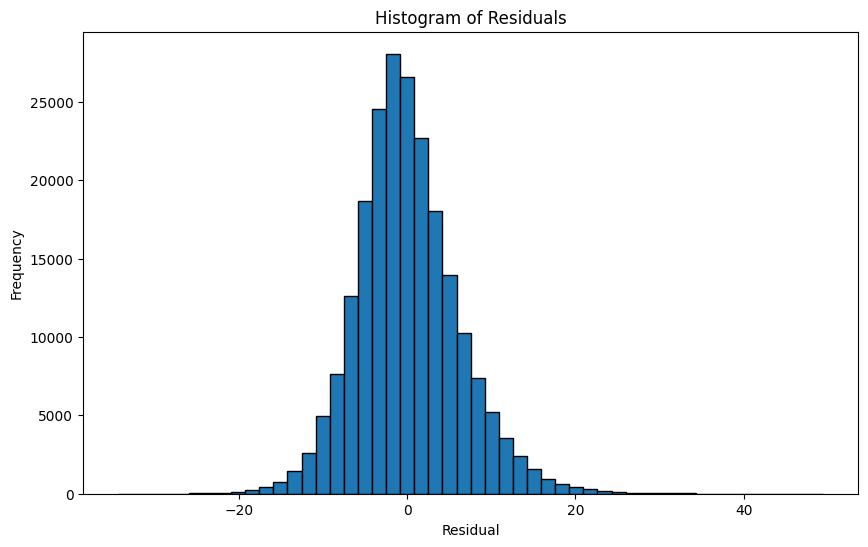

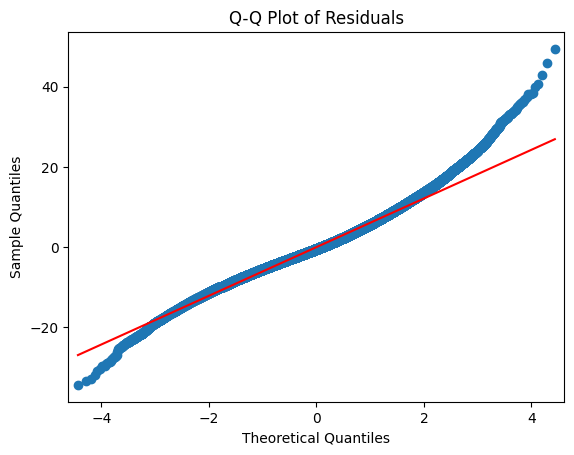

c:\Users\Jordan Nishimura\nba_model_using_player_embeddings\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 216727.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk test p-value: 5.23822498725882e-79
Skewness: 0.45026983417524513
Kurtosis: 1.278278806088121


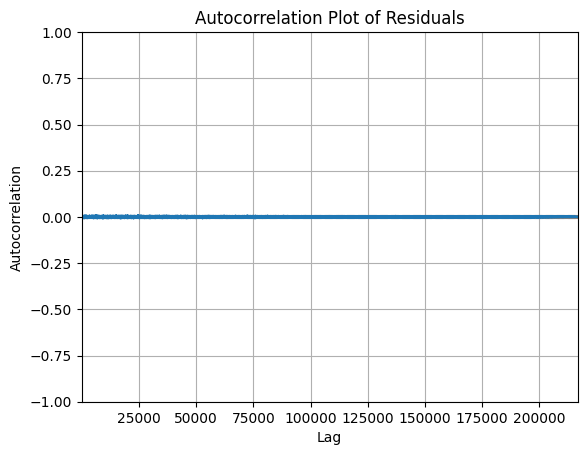

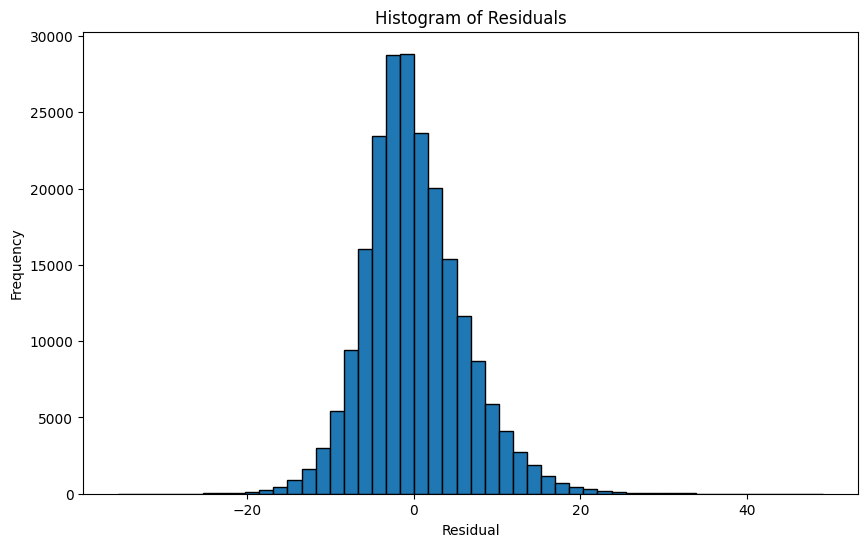

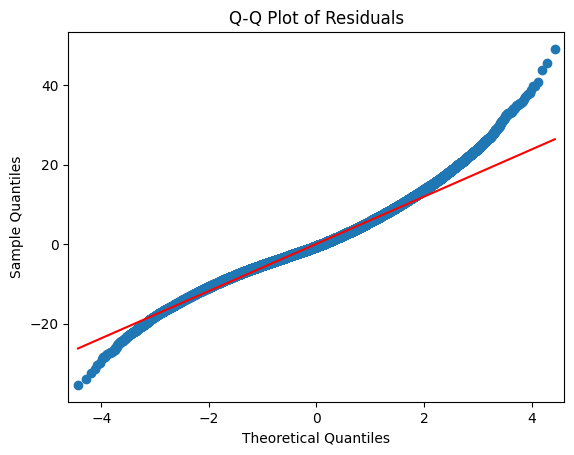

c:\Users\Jordan Nishimura\nba_model_using_player_embeddings\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 215456.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk test p-value: 1.6073302050919183e-84
Skewness: 0.5324904183726242
Kurtosis: 1.3735092405007512


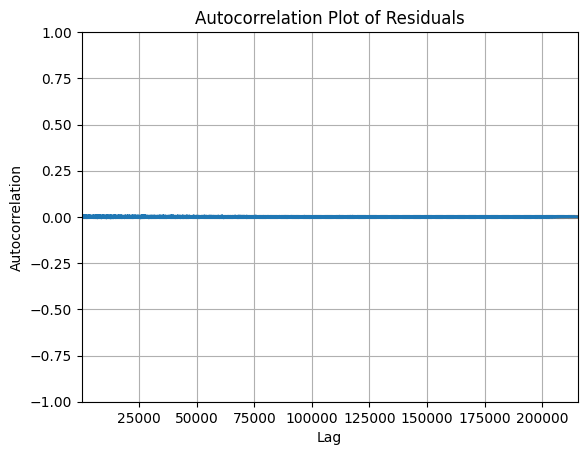

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.graphics.gofplots import qqplot

def analyze_scoring_noise(df: pd.DataFrame, predictions: pd.DataFrame):
    # Merge actual scores with predictions
    df_merged = df.merge(predictions[['PLAYER_ID', 'GAME_DATE', 'PREDICTED_POINTS']], 
                         on=['PLAYER_ID', 'GAME_DATE'], 
                         how='left')
    
    # Calculate residuals
    df_merged['RESIDUALS'] = df_merged['PTS'] - df_merged['PREDICTED_POINTS']
    
    # Remove NaN values
    df_merged = df_merged.dropna(subset=['RESIDUALS'])
    
    residuals = df_merged['RESIDUALS']
    
    # 1. Histogram of residuals
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=50, edgecolor='black')
    plt.title('Histogram of Residuals')
    plt.xlabel('Residual')
    plt.ylabel('Frequency')
    plt.show()
    
    # 2. Q-Q plot
    qqplot(residuals, line='s')
    plt.title('Q-Q Plot of Residuals')
    plt.show()
    
    # 3. Shapiro-Wilk test
    _, p_value = stats.shapiro(residuals)
    print(f"Shapiro-Wilk test p-value: {p_value}")
    
    # 4. Skewness and Kurtosis
    skewness = stats.skew(residuals)
    kurtosis = stats.kurtosis(residuals)
    print(f"Skewness: {skewness}")
    print(f"Kurtosis: {kurtosis}")
    
    # # 5. Autocorrelation plot
    # pd.plotting.autocorrelation_plot(residuals)
    # plt.title('Autocorrelation Plot of Residuals')
    # plt.show()

# Assuming you have your dataframe 'df' and Kalman filter predictions 'kf_predictions'
analyze_scoring_noise(df, kf_predictions)

# For comparison, let's also analyze the EWA residuals
ewa_predictions = predict_ewa(df, best_ewa_span)  # Use your best EWA span
analyze_scoring_noise(df, ewa_predictions)

In [94]:
best_kf_params

{'initial_points': 10, 'measurement_noise': 225, 'process_noise_points': 0.6}

In [65]:
def clean_team_data(df):
    """This function cleans the team_data
    1) Changes W/L to 1/0 
    2) Changes franchise abbreviations to their most 
    recent abbreviation for consistency
    3) Converts GAME_DATE to datetime object
    4) Creates a binary column 'HOME_GAME'
    5) Removes 3 games where advanced stats were not collected
    """
    df = df.copy()
    df['WL'] = (df['WL'] == 'W').astype(int)
    df = df.rename(columns={'SEASON_YEAR': 'SEASON'})

    abbr_mapping = {'NJN': 'BKN',
                    'CHH': 'CHA',
                    'VAN': 'MEM',
                    'NOH': 'NOP',
                    'NOK': 'NOP',
                    'SEA': 'OKC'}

    df['TEAM_ABBREVIATION'] = df['TEAM_ABBREVIATION'].replace(abbr_mapping)
    df['MATCHUP'] = df['MATCHUP'].str.replace('NJN', 'BKN')
    df['MATCHUP'] = df['MATCHUP'].str.replace('CHH', 'CHA')
    df['MATCHUP'] = df['MATCHUP'].str.replace('VAN', 'MEM')
    df['MATCHUP'] = df['MATCHUP'].str.replace('NOH', 'NOP')
    df['MATCHUP'] = df['MATCHUP'].str.replace('NOK', 'NOP')
    df['MATCHUP'] = df['MATCHUP'].str.replace('SEA', 'OKC')

    df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])

    df['HOME_GAME'] = df['MATCHUP'].str.contains('vs').astype(int)

    return df


clean_df = clean_team_data(df)
clean_df

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,SEASON,E_OFF_RATING,E_DEF_RATING,E_NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,E_USG_PCT,E_PACE,POSS,PIE,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM,contestedShots,contestedShots2pt,contestedShots3pt,deflections,chargesDrawn,screenAssists,screenAssistPoints,looseBallsRecoveredOffensive,looseBallsRecoveredDefensive,looseBallsRecoveredTotal,offensiveBoxOuts,defensiveBoxOuts,boxOutPlayerTeamRebounds,boxOutPlayerRebounds,boxOuts,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PASS,CFGM,CFGA,CFG_PCT,UFGM,UFGA,UFG_PCT,DFGM,DFGA,DFG_PCT,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,HOME_GAME
2632,22016,1610612739,CLE,Cleveland Cavaliers,0021600001,2016-10-25,CLE vs. NYK,1,240,45,94,0.479,13,35,0.371,14,19,0.737,11,40,51,31,12,5,15,22,117,29,2016-17,110.0,87.3,22.7,0.689,2.07,20.9,0.353,0.729,0.555,14.103,14.9,0.548,0.572,0.198,103.58,101,0.703,0.628,0.372,0.547,0.103,0.333,0.625,0.375,0.846,0.154,0.689,0.311,65.0,46.0,19.0,16.0,0.0,6.0,12.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,17.12,41.0,72.0,108.0,441.0,2.0,0.0,314.0,17.0,39.0,0.436,28.0,55.0,0.509,10.0,18.0,0.556,21.0,16.0,16.0,52.0,1
2633,22016,1610612752,NYK,New York Knicks,0021600001,2016-10-25,NYK @ CLE,0,240,32,87,0.368,9,27,0.333,15,20,0.750,13,29,42,17,6,6,18,22,88,-29,2016-17,87.3,110.0,-22.7,0.531,0.94,13.0,0.271,0.647,0.445,17.857,17.8,0.420,0.459,0.202,103.58,101,0.297,0.690,0.310,0.523,0.205,0.307,0.391,0.609,0.889,0.111,0.531,0.469,65.0,39.0,26.0,9.0,2.0,7.0,15.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,17.29,34.0,71.0,104.0,408.0,1.0,1.0,287.0,12.0,31.0,0.387,20.0,56.0,0.357,21.0,31.0,0.677,14.0,16.0,9.0,28.0,0
2634,22016,1610612757,POR,Portland Trail Blazers,0021600002,2016-10-25,POR vs. UTA,1,240,39,75,0.520,13,19,0.684,22,22,1.000,5,29,34,22,5,3,13,18,113,9,2016-17,121.9,107.2,14.8,0.564,1.69,18.4,0.222,0.738,0.500,14.027,14.1,0.607,0.667,0.197,94.86,92,0.548,0.747,0.253,0.460,0.159,0.345,0.500,0.500,0.692,0.308,0.564,0.436,62.0,44.0,18.0,9.0,0.0,18.0,43.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,16.65,19.0,54.0,73.0,362.0,0.0,0.0,255.0,19.0,43.0,0.442,20.0,32.0,0.625,14.0,20.0,0.700,20.0,15.0,4.0,34.0,1
2635,22016,1610612762,UTA,Utah Jazz,0021600002,2016-10-25,UTA @ POR,0,240,40,82,0.488,8,24,0.333,16,16,1.000,6,25,31,19,9,5,14,19,104,-9,2016-17,107.2,121.9,-14.8,0.475,1.36,15.6,0.262,0.778,0.500,14.427,15.4,0.537,0.584,0.190,94.86,91,0.452,0.707,0.293,0.615,0.135,0.231,0.344,0.656,1.000,0.000,0.475,0.525,54.0,44.0,10.0,16.0,0.0,10.0,20.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,16.76,19.0,47.0,66.0,425.0,2.0,1.0,310.0,22.0,44.0,0.500,18.0,38.0,0.474,11.0,18.0,0.611,8.0,4.0,8.0,50.0,0
2636,22016,1610612744,GSW,Golden State Warriors,0021600003,2016-10-25,GSW vs. SAS,0,240,40,85,0.471,7,33,0.212,13,18,0.722,8,27,35,24,11,6,16,19,100,-29,2016-17,99.1,125.9,-26.8,0.600,1.50,18.1,0.208,0.528,0.376,15.854,15.8,0.512,0.538,0.198,101.68,101,0.400,0.612,0.388,0.660,0.180,0.210,0.576,0.424,0.714,0.286,0.600,0.400,83.0,62.0,21.0,23.0,0.0,5.0,11.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,16.90,23.0,45.0,67.0,397.0,4.0,1.0,277.0,21.0,38.0,0.553,19.0,47.0,0.404,20.0,32.0,0.625,15.0,4.0,20.0,48.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23043,42023,1610612738,BOS,Boston Celtics,0042300403,2024-06-12,BOS @ DAL,1,240,38,82,0.463,17,46,0.370,13,14,0.929,6,30,36,26,4,6,9,19,106,7,2023-24,116.3,104.2,12.1,0.684,2.89,21.1,0.136,0.750,0.457,9.873,9.8,0.567,0.601,0.200,93.10,92,0.544

In [66]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
clean_df.isnull().sum()

SEASON_ID                         0
TEAM_ID                           0
TEAM_ABBREVIATION                 0
TEAM_NAME                         0
GAME_ID                           0
GAME_DATE                         0
MATCHUP                           0
WL                                0
MIN                               0
FGM                               0
FGA                               0
FG_PCT                            0
FG3M                              0
FG3A                              0
FG3_PCT                           0
FTM                               0
FTA                               0
FT_PCT                            1
OREB                              0
DREB                              0
REB                               0
AST                               0
STL                               0
BLK                               0
TOV                               0
PF                                0
PTS                               0
PLUS_MINUS                  

In [67]:
df.columns

Index(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'SEASON_YEAR',
       'E_OFF_RATING', 'E_DEF_RATING', 'E_NET_RATING', 'AST_PCT', 'AST_TOV',
       'AST_RATIO', 'OREB_PCT', 'DREB_PCT', 'REB_PCT', 'E_TM_TOV_PCT',
       'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'E_USG_PCT', 'E_PACE', 'POSS', 'PIE',
       'PCT_FGA_2PT', 'PCT_FGA_3PT', 'PCT_PTS_2PT', 'PCT_PTS_2PT_MR',
       'PCT_PTS_3PT', 'PCT_AST_2PM', 'PCT_UAST_2PM', 'PCT_AST_3PM',
       'PCT_UAST_3PM', 'PCT_AST_FGM', 'PCT_UAST_FGM', 'contestedShots',
       'contestedShots2pt', 'contestedShots3pt', 'deflections', 'chargesDrawn',
       'screenAssists', 'screenAssistPoints', 'looseBallsRecoveredOffensive',
       'looseBallsRecoveredDefensive', 'looseBallsRecoveredTotal',
       'offensiveBoxOuts', 'defensi

In [198]:
def prep_for_aggregation(df):
    """This function...
    1) Removes categories that are percentages,
    as we will be averaging them and do not want to average 
    percentages. 
    2) Converts shooting percentage stats into raw values"""
    df = df.copy()

    df['FG2M'] = df['FGM'] - df['FG3M']
    df['FG2A'] = df['FGA'] - df['FG3A']
    df['PTS_2PT_MR'] = (df['PTS'] * df['PCT_PTS_2PT_MR']).astype('int8')
    df['AST_2PM'] = (df['FG2M'] * df['PCT_AST_2PM']).astype('int8')
    df['AST_3PM'] = (df['FG3M'] * df['PCT_AST_3PM']).astype('int8')
    df['UAST_2PM'] = (df['FG2M'] * df['PCT_UAST_2PM']).astype('int8')
    df['UAST_3PM'] = (df['FG3M'] * df['PCT_UAST_3PM']).astype('int8')

    df['POINT_DIFF'] = df['PLUS_MINUS']
    df['RECORD'] = df['WL']
    df['TEAM_SCORE'] = df['PTS']
    
    df = df.drop(columns = ['PCT_FGA_2PT', 'PCT_FGA_3PT', 'PCT_PTS_2PT',
                          'PCT_PTS_2PT_MR', 'PCT_PTS_3PT', 'POSS',                       
                          'PCT_AST_2PM', 'PCT_UAST_2PM','PCT_AST_3PM',
                          'PCT_UAST_3PM', 'PCT_AST_FGM', 'PCT_UAST_FGM',
                          'FT_PCT', 'FG_PCT', 'FG3_PCT', 'DREB_PCT',
                          'OREB_PCT', 'REB_PCT', 'AST_PCT', 'AST_TOV', 
                          'AST_RATIO', 'E_TM_TOV_PCT', 'TM_TOV_PCT',
                          'EFG_PCT', 'TS_PCT', 'E_USG_PCT',
                           'MIN', 'PIE', 'CFG_PCT', 'UFG_PCT',
                          'DFG_PCT'])
    
    ## Reorder Columns


    return df


clean_df2 = prep_for_aggregation(clean_df)

clean_df2

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,SEASON,E_OFF_RATING,E_DEF_RATING,E_NET_RATING,E_PACE,contestedShots,contestedShots2pt,contestedShots3pt,deflections,chargesDrawn,screenAssists,screenAssistPoints,looseBallsRecoveredOffensive,looseBallsRecoveredDefensive,looseBallsRecoveredTotal,offensiveBoxOuts,defensiveBoxOuts,boxOutPlayerTeamRebounds,boxOutPlayerRebounds,boxOuts,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PASS,CFGM,CFGA,UFGM,UFGA,DFGM,DFGA,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,HOME_GAME,FG2M,FG2A,PTS_2PT_MR,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM,POINT_DIFF,RECORD,TEAM_SCORE
2632,22016,1610612739,CLE,Cleveland Cavaliers,0021600001,2016-10-25,CLE vs. NYK,1,45,94,13,35,14,19,11,40,51,31,12,5,15,22,117,29,2016-17,110.0,87.3,22.7,103.58,65.0,46.0,19.0,16.0,0.0,6.0,12.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,17.12,41.0,72.0,108.0,441.0,2.0,0.0,314.0,17.0,39.0,28.0,55.0,10.0,18.0,21.0,16.0,16.0,52.0,1,32,59,12,20,10,12,2,29,1,117
2633,22016,1610612752,NYK,New York Knicks,0021600001,2016-10-25,NYK @ CLE,0,32,87,9,27,15,20,13,29,42,17,6,6,18,22,88,-29,2016-17,87.3,110.0,-22.7,103.58,65.0,39.0,26.0,9.0,2.0,7.0,15.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,17.29,34.0,71.0,104.0,408.0,1.0,1.0,287.0,12.0,31.0,20.0,56.0,21.0,31.0,14.0,16.0,9.0,28.0,0,23,60,18,8,8,14,0,-29,0,88
2634,22016,1610612757,POR,Portland Trail Blazers,0021600002,2016-10-25,POR vs. UTA,1,39,75,13,19,22,22,5,29,34,22,5,3,13,18,113,9,2016-17,121.9,107.2,14.8,94.86,62.0,44.0,18.0,9.0,0.0,18.0,43.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,16.65,19.0,54.0,73.0,362.0,0.0,0.0,255.0,19.0,43.0,20.0,32.0,14.0,20.0,20.0,15.0,4.0,34.0,1,26,56,17,13,8,13,4,9,1,113
2635,22016,1610612762,UTA,Utah Jazz,0021600002,2016-10-25,UTA @ POR,0,40,82,8,24,16,16,6,25,31,19,9,5,14,19,104,-9,2016-17,107.2,121.9,-14.8,94.86,54.0,44.0,10.0,16.0,0.0,10.0,20.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,16.76,19.0,47.0,66.0,425.0,2.0,1.0,310.0,22.0,44.0,18.0,38.0,11.0,18.0,8.0,4.0,8.0,50.0,0,32,58,14,11,8,20,0,-9,0,104
2636,22016,1610612744,GSW,Golden State Warriors,0021600003,2016-10-25,GSW vs. SAS,0,40,85,7,33,13,18,8,27,35,24,11,6,16,19,100,-29,2016-17,99.1,125.9,-26.8,101.68,83.0,62.0,21.0,23.0,0.0,5.0,11.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,16.90,23.0,45.0,67.0,397.0,4.0,1.0,277.0,21.0,38.0,19.0,47.0,20.0,32.0,15.0,4.0,20.0,48.0,1,33,52,18,19,4,13,2,-29,0,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23043,42023,1610612738,BOS,Boston Celtics,0042300403,2024-06-12,BOS @ DAL,1,38,82,17,46,13,14,6,30,36,26,4,6,9,19,106,7,2023-24,116.3,104.2,12.1,93.10,45.0,29.0,16.0,8.0,0.0,7.0,16.0,1.0,4.0,5.0,0.0,7.0,6.0,3.0,7.0,16.52,12.0,60.0,72.0,405.0,2.0,0.0,296.0,15.0,26.0,23.0,56.0,17.0,28.0,13.0,6.0,12.0,36.0,0,21,36,6,12,13,8,3,7,1,106
23044,42023,1610612742,DAL,Dallas Mavericks,0042300404,2024-06-14,DAL vs. BOS,1,46,91,15,37,15,22,13,39,52,21,7,2,9,17,122,38,2023-24,126.2,87.8,38.4,96.20,37.0,20.0,17.0,15.0,0.0,11.0,28.0,3.0,2.0,5.0,7.0,5.0,11.0,8.0,12.0,17.63,26.0,59.0,85.0,349.0,1.0,2.0,232.0,17.0,35.0,29.0,56.0,11.0,21.0,17.0,16.0,11.0,60.0,1,31,54,1,7,13,23,1,38,1,122
23045,42023,1610612738,BOS,Boston Celtics,0042300404,2024-06-14,BOS @ DAL,0,29,80,14,41,12,13,4,27,31,18,2,5,14,19,84,-38,2023-24,87.8,126.2,-38.4,96.20,44.0,24.0,20.0,11.0,0.0,6.0,17.0,1.0,2.0,3.0,2.0,3.0,5.0,3.0,5.0,17.26,18.0,55.0,71.0,404.0,6.0,2.0,290.0,11.0,27.0,18.0,53.0,20.0,29.0,9.0,2.0,6.0,26.0,0,15,39,4,7,9,7,4,-38,0,84
23046,42023,1610612742,DAL,Dallas Mavericks,0042300405,2024-06-17,DAL @ BOS,0,35,78,11,37,7,13,7,28,35,18,4,4,13,20,88,-18,2023-24,98.1,115.5,-17.4,90.76,43.0,17.0,26.0,13.0,0.0,11.0,26.0,3.0,1.0,4.0,2.0,6.0,8.0,4.0,8.0,16.67,14.0,56.0,70.0,315.0,1.0,0.0,207.0,13.0,22.0,22.0,56.0,16.0,30.

In [246]:
def find_high_correlations(df, threshold=0.7):
    # Select only numeric columns
    numeric_df = df.select_dtypes(include=[np.number])
    
    # Compute the correlation matrix
    correlation_matrix = numeric_df.corr()
    
    # Create a list to store highly correlated pairs
    high_correlations = []
    
    # Loop through the correlation matrix
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                col1 = correlation_matrix.columns[i]
                col2 = correlation_matrix.columns[j]
                corr_value = correlation_matrix.iloc[i, j]
                high_correlations.append((col1, col2, corr_value))
    
    # Sort the list by absolute correlation value in descending order
    high_correlations.sort(key=lambda x: abs(x[2]), reverse=True)
    
    return high_correlations

# Find highly correlated variables
high_corr_pairs = find_high_correlations(clean_df2, threshold=0.7)

# Print the results
print("Highly correlated variable pairs (correlation > 0.7):")
for col1, col2, corr in high_corr_pairs:
    print(f"{col1} and {col2}: {corr:.2f}")

Highly correlated variable pairs (correlation > 0.7):
REL_E_DEF_RATING_L10 and REL_E_OFF_RATING_opp_L10: 1.00
REL_PLUS_MINUS_L10 and REL_PLUS_MINUS_opp_L10: -1.00
REL_OREB_PCT_opp_L10 and REL_DREB_PCT_L10: -1.00
REL_E_NET_RATING_L10 and REL_E_NET_RATING_opp_L10: -1.00
REL_E_OFF_RATING_L10 and REL_E_DEF_RATING_opp_L10: 1.00
REL_E_PACE_opp_L10 and REL_E_PACE_L10: 1.00
REL_REB_PCT_L10 and REL_REB_PCT_opp_L10: -1.00
REL_OREB_PCT_L10 and REL_DREB_PCT_opp_L10: -1.00
REL_TOV_opp_L10 and REL_TOV_PCT_opp_L10: 0.99
REL_screenAssists_opp_L10 and REL_screenAssistPoints_opp_L10: 0.99
REL_PASS_L10 and REL_TCHS_L10: 0.99
REL_PLUS_MINUS_opp_L10 and REL_E_NET_RATING_opp_L10: 0.99
REL_PLUS_MINUS_L10 and REL_E_NET_RATING_opp_L10: -0.99
REL_E_NET_RATING_L10 and REL_PLUS_MINUS_opp_L10: -0.99
REL_E_NET_RATING_L10 and REL_PLUS_MINUS_L10: 0.99
REL_TOV_PCT_L10 and REL_TOV_L10: 0.98
REL_PASS_opp_L10 and REL_TCHS_opp_L10: 0.98
REL_screenAssists_L10 and REL_screenAssistPoints_L10: 0.98
REL_PTS_L10 and REL_E_DEF_R

In [247]:
high_corr_pairs

[('REL_E_DEF_RATING_L10', 'REL_E_OFF_RATING_opp_L10', 1.0),
 ('REL_PLUS_MINUS_L10', 'REL_PLUS_MINUS_opp_L10', -1.0),
 ('REL_OREB_PCT_opp_L10', 'REL_DREB_PCT_L10', -1.0),
 ('REL_E_NET_RATING_L10', 'REL_E_NET_RATING_opp_L10', -1.0),
 ('REL_E_OFF_RATING_L10', 'REL_E_DEF_RATING_opp_L10', 1.0),
 ('REL_E_PACE_opp_L10', 'REL_E_PACE_L10', 1.0),
 ('REL_REB_PCT_L10', 'REL_REB_PCT_opp_L10', -0.9999999999999998),
 ('REL_OREB_PCT_L10', 'REL_DREB_PCT_opp_L10', -0.9999999999999998),
 ('REL_TOV_opp_L10', 'REL_TOV_PCT_opp_L10', 0.9902291776746244),
 ('REL_screenAssists_opp_L10',
  'REL_screenAssistPoints_opp_L10',
  0.9890193015571056),
 ('REL_PASS_L10', 'REL_TCHS_L10', 0.9884518974321779),
 ('REL_PLUS_MINUS_opp_L10', 'REL_E_NET_RATING_opp_L10', 0.9854770826463026),
 ('REL_PLUS_MINUS_L10', 'REL_E_NET_RATING_opp_L10', -0.9854770826463026),
 ('REL_E_NET_RATING_L10', 'REL_PLUS_MINUS_opp_L10', -0.9854770826463026),
 ('REL_E_NET_RATING_L10', 'REL_PLUS_MINUS_L10', 0.9854770826463026),
 ('REL_TOV_PCT_L10', 'R

In [200]:
def normalize_per_100_poss(df):
    df = df.copy(deep=True)
    
    stats = ['FGM', 'FGA', 'FG3M', 'FG3A', 'FTM',
       'FTA', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'PLUS_MINUS', 'contestedShots',
       'contestedShots2pt', 'contestedShots3pt', 'deflections', 'chargesDrawn',
       'screenAssists', 'screenAssistPoints', 'looseBallsRecoveredOffensive',
       'looseBallsRecoveredDefensive', 'looseBallsRecoveredTotal',
       'offensiveBoxOuts', 'defensiveBoxOuts', 'boxOutPlayerTeamRebounds',
       'boxOutPlayerRebounds', 'boxOuts', 'DIST', 'ORBC', 'DRBC', 'RBC',
       'TCHS', 'SAST', 'FTAST', 'PASS', 'CFGM', 'CFGA', 'UFGM', 'UFGA', 'DFGM',
       'DFGA', 'PTS_OFF_TOV', 'PTS_2ND_CHANCE', 'PTS_FB', 'PTS_PAINT',
        'FG2M', 'FG2A', 'PTS_2PT_MR', 'AST_2PM', 'AST_3PM',
       'UAST_2PM', 'UAST_3PM']
    
    df[stats] = 100*df[stats].div(df['E_PACE'], axis=0) 
    
    return df
 
normalized_df = normalize_per_100_poss(clean_df2)
normalized_df

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,SEASON,E_OFF_RATING,E_DEF_RATING,E_NET_RATING,E_PACE,contestedShots,contestedShots2pt,contestedShots3pt,deflections,chargesDrawn,screenAssists,screenAssistPoints,looseBallsRecoveredOffensive,looseBallsRecoveredDefensive,looseBallsRecoveredTotal,offensiveBoxOuts,defensiveBoxOuts,boxOutPlayerTeamRebounds,boxOutPlayerRebounds,boxOuts,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PASS,CFGM,CFGA,UFGM,UFGA,DFGM,DFGA,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,HOME_GAME,FG2M,FG2A,PTS_2PT_MR,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM,POINT_DIFF,RECORD,TEAM_SCORE
2632,22016,1610612739,CLE,Cleveland Cavaliers,0021600001,2016-10-25,CLE vs. NYK,1,43.444680,90.751110,12.550685,33.790307,13.516123,18.343310,10.619811,38.617494,49.237304,29.928558,11.585248,4.827187,14.481560,21.239622,112.956169,27.997683,2016-17,110.0,87.3,22.7,103.58,62.753427,44.410118,18.343310,15.446997,0.000000,5.792624,11.585248,0.000000,0.000000,11.585248,0.000000,0.000000,0.000000,0.000000,0.000000,16.528287,39.582931,69.511489,104.267233,425.757868,1.930875,0.000000,303.147326,16.412435,37.652056,27.032246,53.099054,9.654373,17.377872,20.274184,15.446997,15.446997,50.202742,1,30.893995,56.960803,11.585248,19.308747,9.654373,11.585248,1.930875,29,1,117
2633,22016,1610612752,NYK,New York Knicks,0021600001,2016-10-25,NYK @ CLE,0,30.893995,83.993049,8.688936,26.066808,14.481560,19.308747,12.550685,27.997683,40.548368,16.412435,5.792624,5.792624,17.377872,21.239622,84.958486,-27.997683,2016-17,87.3,110.0,-22.7,103.58,62.753427,37.652056,25.101371,8.688936,1.930875,6.758061,14.481560,0.000000,0.000000,9.654373,0.000000,0.000000,0.000000,0.000000,0.000000,16.692412,32.824870,68.546051,100.405484,393.898436,0.965437,0.965437,277.080517,11.585248,29.928558,19.308747,54.064491,20.274184,29.928558,13.516123,15.446997,8.688936,27.032246,0,22.205059,57.926241,17.377872,7.723499,7.723499,13.516123,0.000000,-29,0,88
2634,22016,1610612757,POR,Portland Trail Blazers,0021600002,2016-10-25,POR vs. UTA,1,41.113219,79.063884,13.704406,20.029517,23.192073,23.192073,5.270926,30.571368,35.842294,23.192073,5.270926,3.162555,13.704406,18.975332,119.122918,9.487666,2016-17,121.9,107.2,14.8,94.86,65.359477,46.384145,18.975332,9.487666,0.000000,18.975332,45.329960,0.000000,0.000000,4.216740,0.000000,0.000000,0.000000,0.000000,0.000000,17.552182,20.029517,56.925996,76.955513,381.615012,0.000000,0.000000,268.817204,20.029517,45.329960,21.083702,33.733924,14.758592,21.083702,21.083702,15.812777,4.216740,35.842294,1,27.408813,59.034366,17.921147,13.704406,8.433481,13.704406,4.216740,9,1,113
2635,22016,1610612762,UTA,Utah Jazz,0021600002,2016-10-25,UTA @ POR,0,42.167405,86.443179,8.433481,25.300443,16.866962,16.866962,6.325111,26.354628,32.679739,20.029517,9.487666,5.270926,14.758592,20.029517,109.635252,-9.487666,2016-17,107.2,121.9,-14.8,94.86,56.925996,46.384145,10.541851,16.866962,0.000000,10.541851,21.083702,0.000000,0.000000,7.379296,0.000000,0.000000,0.000000,0.000000,0.000000,17.668143,20.029517,49.546700,69.576218,448.028674,2.108370,1.054185,326.797386,23.192073,46.384145,18.975332,40.059034,11.596036,18.975332,8.433481,4.216740,8.433481,52.709256,0,33.733924,61.142737,14.758592,11.596036,8.433481,21.083702,0.000000,-9,0,104
2636,22016,1610612744,GSW,Golden State Warriors,0021600003,2016-10-25,GSW vs. SAS,0,39.339103,83.595594,6.884343,32.454760,12.785208,17.702596,7.867821,26.553895,34.421715,23.603462,10.818253,5.900865,15.735641,18.686074,98.347758,-28.520850,2016-17,99.1,125.9,-26.8,101.68,81.628639,60.975610,20.653029,22.619984,0.000000,4.917388,10.818253,0.000000,0.000000,7.867821,0.000000,0.000000,0.000000,0.000000,0.000000,16.620771,22.619984,44.256491,65.892998,390.440598,3.933910,0.983478,272.423289,20.653029,37.372148,18.686074,46.223446,19.669552,31.471282,14.752164,3.933910,19.669552,47.206924,1,32.454760,51.140834,17.702596,18.686074,3.933910,12.

In [98]:
normalized_df.columns

Index(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM',
       'FTA', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'PLUS_MINUS', 'SEASON', 'E_PACE', 'contestedShots', 'contestedShots2pt',
       'contestedShots3pt', 'deflections', 'chargesDrawn', 'screenAssists',
       'screenAssistPoints', 'looseBallsRecoveredOffensive',
       'looseBallsRecoveredDefensive', 'looseBallsRecoveredTotal',
       'offensiveBoxOuts', 'defensiveBoxOuts', 'boxOutPlayerTeamRebounds',
       'boxOutPlayerRebounds', 'boxOuts', 'DIST', 'ORBC', 'DRBC', 'RBC',
       'TCHS', 'SAST', 'FTAST', 'PASS', 'CFGM', 'CFGA', 'UFGM', 'UFGA', 'DFGM',
       'DFGA', 'PTS_OFF_TOV', 'PTS_2ND_CHANCE', 'PTS_FB', 'PTS_PAINT',
       'HOME_GAME', 'FG2M', 'FG2A', 'PTS_2PT_MR', 'AST_2PM', 'AST_3PM',
       'UAST_2PM', 'UAST_3PM', 'POINT_DIFF', 'RECORD', 'TEAM_SCORE'],
      dtype='object')

## Add Betting Data

In [201]:
def load_betting_data(conn):
    betting_data = pd.read_sql("SELECT * FROM nba_odds", conn)
    betting_data = betting_data[['season', 'date', 'status', 'home_team_abbr', 'away_team_abbr', 'home_spread_draftkings',
                                'home_spread_odds_draftkings',
                                'away_spread_draftkings',
                                'away_spread_odds_draftkings',
                                'home_ml_draftkings',
                                'away_ml_draftkings',
                                'total_draftkings',
                                'over_odds_draftkings',
                                'under_odds_draftkings']]
    return betting_data


connection = sqlite3.connect("nba_stats.db")
betting_data = load_betting_data(connection)
betting_data

connection.close()

In [202]:
def convert_american_to_decimal(x):
    return np.where(x>0, (100+x)/100, 1+(100.0/-x))          

In [203]:
normalized_df

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,SEASON,E_OFF_RATING,E_DEF_RATING,E_NET_RATING,E_PACE,contestedShots,contestedShots2pt,contestedShots3pt,deflections,chargesDrawn,screenAssists,screenAssistPoints,looseBallsRecoveredOffensive,looseBallsRecoveredDefensive,looseBallsRecoveredTotal,offensiveBoxOuts,defensiveBoxOuts,boxOutPlayerTeamRebounds,boxOutPlayerRebounds,boxOuts,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PASS,CFGM,CFGA,UFGM,UFGA,DFGM,DFGA,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,HOME_GAME,FG2M,FG2A,PTS_2PT_MR,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM,POINT_DIFF,RECORD,TEAM_SCORE
2632,22016,1610612739,CLE,Cleveland Cavaliers,0021600001,2016-10-25,CLE vs. NYK,1,43.444680,90.751110,12.550685,33.790307,13.516123,18.343310,10.619811,38.617494,49.237304,29.928558,11.585248,4.827187,14.481560,21.239622,112.956169,27.997683,2016-17,110.0,87.3,22.7,103.58,62.753427,44.410118,18.343310,15.446997,0.000000,5.792624,11.585248,0.000000,0.000000,11.585248,0.000000,0.000000,0.000000,0.000000,0.000000,16.528287,39.582931,69.511489,104.267233,425.757868,1.930875,0.000000,303.147326,16.412435,37.652056,27.032246,53.099054,9.654373,17.377872,20.274184,15.446997,15.446997,50.202742,1,30.893995,56.960803,11.585248,19.308747,9.654373,11.585248,1.930875,29,1,117
2633,22016,1610612752,NYK,New York Knicks,0021600001,2016-10-25,NYK @ CLE,0,30.893995,83.993049,8.688936,26.066808,14.481560,19.308747,12.550685,27.997683,40.548368,16.412435,5.792624,5.792624,17.377872,21.239622,84.958486,-27.997683,2016-17,87.3,110.0,-22.7,103.58,62.753427,37.652056,25.101371,8.688936,1.930875,6.758061,14.481560,0.000000,0.000000,9.654373,0.000000,0.000000,0.000000,0.000000,0.000000,16.692412,32.824870,68.546051,100.405484,393.898436,0.965437,0.965437,277.080517,11.585248,29.928558,19.308747,54.064491,20.274184,29.928558,13.516123,15.446997,8.688936,27.032246,0,22.205059,57.926241,17.377872,7.723499,7.723499,13.516123,0.000000,-29,0,88
2634,22016,1610612757,POR,Portland Trail Blazers,0021600002,2016-10-25,POR vs. UTA,1,41.113219,79.063884,13.704406,20.029517,23.192073,23.192073,5.270926,30.571368,35.842294,23.192073,5.270926,3.162555,13.704406,18.975332,119.122918,9.487666,2016-17,121.9,107.2,14.8,94.86,65.359477,46.384145,18.975332,9.487666,0.000000,18.975332,45.329960,0.000000,0.000000,4.216740,0.000000,0.000000,0.000000,0.000000,0.000000,17.552182,20.029517,56.925996,76.955513,381.615012,0.000000,0.000000,268.817204,20.029517,45.329960,21.083702,33.733924,14.758592,21.083702,21.083702,15.812777,4.216740,35.842294,1,27.408813,59.034366,17.921147,13.704406,8.433481,13.704406,4.216740,9,1,113
2635,22016,1610612762,UTA,Utah Jazz,0021600002,2016-10-25,UTA @ POR,0,42.167405,86.443179,8.433481,25.300443,16.866962,16.866962,6.325111,26.354628,32.679739,20.029517,9.487666,5.270926,14.758592,20.029517,109.635252,-9.487666,2016-17,107.2,121.9,-14.8,94.86,56.925996,46.384145,10.541851,16.866962,0.000000,10.541851,21.083702,0.000000,0.000000,7.379296,0.000000,0.000000,0.000000,0.000000,0.000000,17.668143,20.029517,49.546700,69.576218,448.028674,2.108370,1.054185,326.797386,23.192073,46.384145,18.975332,40.059034,11.596036,18.975332,8.433481,4.216740,8.433481,52.709256,0,33.733924,61.142737,14.758592,11.596036,8.433481,21.083702,0.000000,-9,0,104
2636,22016,1610612744,GSW,Golden State Warriors,0021600003,2016-10-25,GSW vs. SAS,0,39.339103,83.595594,6.884343,32.454760,12.785208,17.702596,7.867821,26.553895,34.421715,23.603462,10.818253,5.900865,15.735641,18.686074,98.347758,-28.520850,2016-17,99.1,125.9,-26.8,101.68,81.628639,60.975610,20.653029,22.619984,0.000000,4.917388,10.818253,0.000000,0.000000,7.867821,0.000000,0.000000,0.000000,0.000000,0.000000,16.620771,22.619984,44.256491,65.892998,390.440598,3.933910,0.983478,272.423289,20.653029,37.372148,18.686074,46.223446,19.669552,31.471282,14.752164,3.933910,19.669552,47.206924,1,32.454760,51.140834,17.702596,18.686074,3.933910,12.

In [204]:
def clean_betting_data(df):
    abbr_mapping = {'BK':'BKN',
                    'GS':'GSW',
                    'NO':'NOP',
                    'NY':'NYK',
                    'PHO':'PHX',
                    'SA':'SAS'
                    }

    df['home_team_abbr'] = df['home_team_abbr'].replace(abbr_mapping)
    df['away_team_abbr'] = df['away_team_abbr'].replace(abbr_mapping)

    df['date'] = pd.to_datetime(df['date']).dt.date
    df['GAME_DATE'] = df['date'] - pd.Timedelta(days=1)

    df['home_spread_odds_draftkings'] = convert_american_to_decimal(df['home_spread_odds_draftkings'])
    df['away_spread_odds_draftkings'] = convert_american_to_decimal(df['away_spread_odds_draftkings'])

    df['home_ml_draftkings'] = convert_american_to_decimal(df['home_ml_draftkings'])
    df['away_ml_draftkings'] = convert_american_to_decimal(df['away_ml_draftkings'])
    
    df['over_odds_draftkings'] = convert_american_to_decimal(df['over_odds_draftkings'])
    df['under_odds_draftkings'] = convert_american_to_decimal(df['under_odds_draftkings'])

    return df

In [205]:
clean_betting_df = clean_betting_data(betting_data)

In [206]:
clean_betting_df.head()

,season,date,status,home_team_abbr,away_team_abbr,home_spread_draftkings,home_spread_odds_draftkings,away_spread_draftkings,away_spread_odds_draftkings,home_ml_draftkings,away_ml_draftkings,total_draftkings,over_odds_draftkings,under_odds_draftkings,GAME_DATE
0,2019-20,2020-10-11,Final,MIA,LAL,6.0,1.909091,-6.0,1.909091,3.150000,1.377358,214.5,1.925926,1.884956,2020-10-10
1,2019-20,2020-10-11,Final,MIA,LAL,6.0,1.909091,-6.0,1.909091,3.150000,1.377358,214.5,1.925926,1.884956,2020-10-10
2,2019-20,2020-10-10,Final,LAL,MIA,-7.0,1.892857,7.0,1.925926,1.298507,3.700000,215.5,1.892857,1.917431,2020-10-09
3,2019-20,2020-10-07,Final,MIA,LAL,7.5,1.909091,-7.5,1.909091,3.750000,1.298507,218.5,1.884956,1.925926,2020-10-06
4,2019-20,2020-10-04,Final,MIA,LAL,9.5,1.909091,-9.5,1.909091,4.500000,1.219780,219.5,1.884956,1.925926,2020-10-03


In [207]:
normalized_df['GAME_DATE'] = pd.to_datetime(normalized_df['GAME_DATE'])

betting_data['season'].unique()

array(['2019-20', '2020-21', '2021-22', '2022-23', '2023-24'],
      dtype=object)

In [208]:
clean_betting_df[['season', 'date', 'GAME_DATE', 'home_team_abbr', 'away_team_abbr']]

,season,date,GAME_DATE,home_team_abbr,away_team_abbr
0,2019-20,2020-10-11,2020-10-10,MIA,LAL
1,2019-20,2020-10-11,2020-10-10,MIA,LAL
2,2019-20,2020-10-10,2020-10-09,LAL,MIA
3,2019-20,2020-10-07,2020-10-06,MIA,LAL
4,2019-20,2020-10-04,2020-10-03,MIA,LAL
...,...,...,...,...,...
6456,2023-24,2024-06-07,2024-06-06,BOS,DAL
6457,2023-24,2024-06-10,2024-06-09,BOS,DAL
6458,2023-24,2024-06-13,2024-06-12,DAL,BOS
6459,2023-24,2024-06-15,2024-06-14,DAL,BOS


In [209]:
# Create copy of input DataFrames to avoid modifying originals
clean_boxscores = normalized_df.copy()
clean_betting_df = clean_betting_df.copy()

# Ensure date columns are in the same format
clean_boxscores['GAME_DATE'] = pd.to_datetime(clean_boxscores['GAME_DATE']) #.dt.tz_localize(None)
clean_betting_df['GAME_DATE'] = pd.to_datetime(clean_betting_df['GAME_DATE']) #.dt.tz_localize(None)    

clean_boxscores['HOME_TEAM'] = clean_boxscores['MATCHUP'].apply(
    lambda x: x[:3] if 'vs' in x else x[-3:])
clean_boxscores['AWAY_TEAM'] = clean_boxscores['MATCHUP'].apply(
    lambda x: x[:3] if '@' in x else x[-3:])


merged_df = pd.merge(clean_boxscores, clean_betting_df, how='left', 
                        left_on=['HOME_TEAM', 'AWAY_TEAM', 'GAME_DATE'],
                        right_on=['home_team_abbr', 'away_team_abbr', 'GAME_DATE'])


merged_df['ML'] = merged_df.apply(lambda row: row['home_ml_draftkings'] if row['HOME_GAME'] == 1
                                    else row['away_ml_draftkings'], axis=1)

merged_df['SPREAD'] = merged_df.apply(lambda row: row['home_spread_odds_draftkings'] if row['HOME_GAME'] == 1
                                        else -row['away_spread_odds_draftkings'], axis=1)


merged_df['SPREAD_ODDS'] = merged_df.apply(lambda row: row['home_spread_draftkings'] if row['HOME_GAME'] == 1
                                        else -row['away_spread_draftkings'], axis=1)


merged_df = merged_df.drop(columns=['HOME_TEAM', 'AWAY_TEAM', 'date'])

merged_df['ATS_DIFF'] = merged_df['POINT_DIFF'] + merged_df['SPREAD']

merged_df['TEAM_COVERED'] = (merged_df['ATS_DIFF'] > 0).astype(int)


In [210]:
def merge_betting_and_boxscore_data(clean_betting_df, clean_boxscores):
    
    # Create copy of input DataFrames to avoid modifying originals
    clean_boxscores = clean_boxscores.copy()
    clean_betting_df = clean_betting_df.copy()

    # Ensure date columns are in the same format
    clean_boxscores['GAME_DATE'] = pd.to_datetime(clean_boxscores['GAME_DATE']) #.dt.tz_localize(None)
    clean_betting_df['GAME_DATE'] = pd.to_datetime(clean_betting_df['GAME_DATE']) #.dt.tz_localize(None)    

    clean_boxscores['HOME_TEAM'] = clean_boxscores['MATCHUP'].apply(
        lambda x: x[:3] if 'vs' in x else x[-3:])
    clean_boxscores['AWAY_TEAM'] = clean_boxscores['MATCHUP'].apply(
        lambda x: x[:3] if '@' in x else x[-3:])


    merged_df = pd.merge(clean_boxscores, clean_betting_df, how='left', 
                            left_on=['HOME_TEAM', 'AWAY_TEAM', 'GAME_DATE'],
                            right_on=['home_team_abbr', 'away_team_abbr', 'GAME_DATE'])

    merged_df['ML'] = merged_df.apply(lambda row: row['home_ml_draftkings'] if row['HOME_GAME'] == 1
                                      else row['away_ml_draftkings'], axis=1)

    merged_df['SPREAD'] = merged_df.apply(lambda row: row['home_spread_odds_draftkings'] if row['HOME_GAME'] == 1
                                          else -row['away_spread_odds_draftkings'], axis=1)
    
    
    merged_df['SPREAD_ODDS'] = merged_df.apply(lambda row: row['home_spread_draftkings'] if row['HOME_GAME'] == 1
                                          else -row['away_spread_draftkings'], axis=1)
    

    merged_df = merged_df.drop(columns=['HOME_TEAM', 'AWAY_TEAM', 'date'])

    merged_df['ATS_DIFF'] = merged_df['POINT_DIFF'] + merged_df['SPREAD']

    merged_df['TEAM_COVERED'] = (merged_df['ATS_DIFF'] > 0).astype(int)
    
#     merged_df.loc[merged_df['ATS_DIFF'] == 0.0, 'TEAM_COVERED'] = 0.5

    return merged_df


merged_df = merge_betting_and_boxscore_data(clean_betting_df, clean_boxscores=normalized_df)

merged_df

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,SEASON,E_OFF_RATING,E_DEF_RATING,E_NET_RATING,E_PACE,contestedShots,contestedShots2pt,contestedShots3pt,deflections,chargesDrawn,screenAssists,screenAssistPoints,looseBallsRecoveredOffensive,looseBallsRecoveredDefensive,looseBallsRecoveredTotal,offensiveBoxOuts,defensiveBoxOuts,boxOutPlayerTeamRebounds,boxOutPlayerRebounds,boxOuts,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PASS,CFGM,CFGA,UFGM,UFGA,DFGM,DFGA,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,HOME_GAME,FG2M,FG2A,PTS_2PT_MR,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM,POINT_DIFF,RECORD,TEAM_SCORE,season,status,home_team_abbr,away_team_abbr,home_spread_draftkings,home_spread_odds_draftkings,away_spread_draftkings,away_spread_odds_draftkings,home_ml_draftkings,away_ml_draftkings,total_draftkings,over_odds_draftkings,under_odds_draftkings,ML,SPREAD,SPREAD_ODDS,ATS_DIFF,TEAM_COVERED
0,22016,1610612739,CLE,Cleveland Cavaliers,0021600001,2016-10-25,CLE vs. NYK,1,43.444680,90.751110,12.550685,33.790307,13.516123,18.343310,10.619811,38.617494,49.237304,29.928558,11.585248,4.827187,14.481560,21.239622,112.956169,27.997683,2016-17,110.0,87.3,22.7,103.58,62.753427,44.410118,18.343310,15.446997,0.000000,5.792624,11.585248,0.000000,0.000000,11.585248,0.000000,0.000000,0.000000,0.000000,0.000000,16.528287,39.582931,69.511489,104.267233,425.757868,1.930875,0.000000,303.147326,16.412435,37.652056,27.032246,53.099054,9.654373,17.377872,20.274184,15.446997,15.446997,50.202742,1,30.893995,56.960803,11.585248,19.308747,9.654373,11.585248,1.930875,29,1,117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,22016,1610612752,NYK,New York Knicks,0021600001,2016-10-25,NYK @ CLE,0,30.893995,83.993049,8.688936,26.066808,14.481560,19.308747,12.550685,27.997683,40.548368,16.412435,5.792624,5.792624,17.377872,21.239622,84.958486,-27.997683,2016-17,87.3,110.0,-22.7,103.58,62.753427,37.652056,25.101371,8.688936,1.930875,6.758061,14.481560,0.000000,0.000000,9.654373,0.000000,0.000000,0.000000,0.000000,0.000000,16.692412,32.824870,68.546051,100.405484,393.898436,0.965437,0.965437,277.080517,11.585248,29.928558,19.308747,54.064491,20.274184,29.928558,13.516123,15.446997,8.688936,27.032246,0,22.205059,57.926241,17.377872,7.723499,7.723499,13.516123,0.000000,-29,0,88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,22016,1610612757,POR,Portland Trail Blazers,0021600002,2016-10-25,POR vs. UTA,1,41.113219,79.063884,13.704406,20.029517,23.192073,23.192073,5.270926,30.571368,35.842294,23.192073,5.270926,3.162555,13.704406,18.975332,119.122918,9.487666,2016-17,121.9,107.2,14.8,94.86,65.359477,46.384145,18.975332,9.487666,0.000000,18.975332,45.329960,0.000000,0.000000,4.216740,0.000000,0.000000,0.000000,0.000000,0.000000,17.552182,20.029517,56.925996,76.955513,381.615012,0.000000,0.000000,268.817204,20.029517,45.329960,21.083702,33.733924,14.758592,21.083702,21.083702,15.812777,4.216740,35.842294,1,27.408813,59.034366,17.921147,13.704406,8.433481,13.704406,4.216740,9,1,113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,22016,1610612762,UTA,Utah Jazz,0021600002,2016-10-25,UTA @ POR,0,42.167405,86.443179,8.433481,25.300443,16.866962,16.866962,6.325111,26.354628,32.679739,20.029517,9.487666,5.270926,14.758592,20.029517,109.635252,-9.487666,2016-17,107.2,121.9,-14.8,94.86,56.925996,46.384145,10.541851,16.866962,0.000000,10.541851,21.083702,0.000000,0.000000,7.379296,0.000000,0.000000,0.000000,0.000000,0.000000,17.668143,20.029517,49.546700,69.576218,448.028674,2.108370,1.054185,326.797386,23.192073,46.384145,18.975332,40.059034,11.596036,18.975332,8.433481,4.216740,8.433481,52.709256,0,33.733924,61.142737,14.758592,11.596036,8.433481,21.083702,0.000000,-9,0,104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,22016,1610612744,GSW,Golden State Warriors,0021600003,2016-10-25,GSW vs. SAS,0,39.339103,

In [211]:
def create_matchups(df):
    """This function makes each row a matchup between 
    team and opp"""
    df = df.copy()
    
    
    matchups = pd.merge(df, df, on=['GAME_ID'], suffixes=['', '_opp'])
    matchups = matchups.loc[matchups['TEAM_ABBREVIATION'] != matchups['TEAM_ABBREVIATION_opp']]

    matchups = matchups.drop(columns = ['SEASON_opp', 'SEASON_ID_opp',
                             'TEAM_ABBREVIATION_opp', 'GAME_DATE_opp',
                             'MATCHUP_opp', 'HOME_GAME_opp', 'TEAM_NAME_opp',
                                       'TEAM_ID_opp', 'WL_opp']
                 )
    
    matchups
    
    return matchups


matchups = create_matchups(normalized_df)
matchups.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,SEASON,E_OFF_RATING,E_DEF_RATING,E_NET_RATING,E_PACE,contestedShots,contestedShots2pt,contestedShots3pt,deflections,chargesDrawn,screenAssists,screenAssistPoints,looseBallsRecoveredOffensive,looseBallsRecoveredDefensive,looseBallsRecoveredTotal,offensiveBoxOuts,defensiveBoxOuts,boxOutPlayerTeamRebounds,boxOutPlayerRebounds,boxOuts,DIST,ORBC,DRBC,RBC,TCHS,SAST,FTAST,PASS,CFGM,CFGA,UFGM,UFGA,DFGM,DFGA,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,HOME_GAME,FG2M,FG2A,PTS_2PT_MR,AST_2PM,AST_3PM,UAST_2PM,UAST_3PM,POINT_DIFF,RECORD,TEAM_SCORE,FGM_opp,FGA_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,E_DEF_RATING_opp,E_NET_RATING_opp,E_PACE_opp,contestedShots_opp,contestedShots2pt_opp,contestedShots3pt_opp,deflections_opp,chargesDrawn_opp,screenAssists_opp,screenAssistPoints_opp,looseBallsRecoveredOffensive_opp,looseBallsRecoveredDefensive_opp,looseBallsRecoveredTotal_opp,offensiveBoxOuts_opp,defensiveBoxOuts_opp,boxOutPlayerTeamRebounds_opp,boxOutPlayerRebounds_opp,boxOuts_opp,DIST_opp,ORBC_opp,DRBC_opp,RBC_opp,TCHS_opp,SAST_opp,FTAST_opp,PASS_opp,CFGM_opp,CFGA_opp,UFGM_opp,UFGA_opp,DFGM_opp,DFGA_opp,PTS_OFF_TOV_opp,PTS_2ND_CHANCE_opp,PTS_FB_opp,PTS_PAINT_opp,FG2M_opp,FG2A_opp,PTS_2PT_MR_opp,AST_2PM_opp,AST_3PM_opp,UAST_2PM_opp,UAST_3PM_opp,POINT_DIFF_opp,RECORD_opp,TEAM_SCORE_opp
1,22016,1610612739,CLE,Cleveland Cavaliers,0021600001,2016-10-25,CLE vs. NYK,1,43.444680,90.751110,12.550685,33.790307,13.516123,18.343310,10.619811,38.617494,49.237304,29.928558,11.585248,4.827187,14.481560,21.239622,112.956169,27.997683,2016-17,110.0,87.3,22.7,103.58,62.753427,44.410118,18.343310,15.446997,0.000000,5.792624,11.585248,0.0,0.0,11.585248,0.0,0.0,0.0,0.0,0.0,16.528287,39.582931,69.511489,104.267233,425.757868,1.930875,0.000000,303.147326,16.412435,37.652056,27.032246,53.099054,9.654373,17.377872,20.274184,15.446997,15.446997,50.202742,1,30.893995,56.960803,11.585248,19.308747,9.654373,11.585248,1.930875,29,1,117,30.893995,83.993049,8.688936,26.066808,14.481560,19.308747,12.550685,27.997683,40.548368,16.412435,5.792624,5.792624,17.377872,21.239622,84.958486,-27.997683,87.3,110.0,-22.7,103.58,62.753427,37.652056,25.101371,8.688936,1.930875,6.758061,14.481560,0.0,0.0,9.654373,0.0,0.0,0.0,0.0,0.0,16.692412,32.824870,68.546051,100.405484,393.898436,0.965437,0.965437,277.080517,11.585248,29.928558,19.308747,54.064491,20.274184,29.928558,13.516123,15.446997,8.688936,27.032246,22.205059,57.926241,17.377872,7.723499,7.723499,13.516123,0.000000,-29,0,88
2,22016,1610612752,NYK,New York Knicks,0021600001,2016-10-25,NYK @ CLE,0,30.893995,83.993049,8.688936,26.066808,14.481560,19.308747,12.550685,27.997683,40.548368,16.412435,5.792624,5.792624,17.377872,21.239622,84.958486,-27.997683,2016-17,87.3,110.0,-22.7,103.58,62.753427,37.652056,25.101371,8.688936,1.930875,6.758061,14.481560,0.0,0.0,9.654373,0.0,0.0,0.0,0.0,0.0,16.692412,32.824870,68.546051,100.405484,393.898436,0.965437,0.965437,277.080517,11.585248,29.928558,19.308747,54.064491,20.274184,29.928558,13.516123,15.446997,8.688936,27.032246,0,22.205059,57.926241,17.377872,7.723499,7.723499,13.516123,0.000000,-29,0,88,43.444680,90.751110,12.550685,33.790307,13.516123,18.343310,10.619811,38.617494,49.237304,29.928558,11.585248,4.827187,14.481560,21.239622,112.956169,27.997683,110.0,87.3,22.7,103.58,62.753427,44.410118,18.343310,15.446997,0.000000,5.792624,11.585248,0.0,0.0,11.585248,0.0,0.0,0.0,0.0,0.0,16.528287,39.582931,69.511489,104.267233,425.757868,1.930875,0.000000,303.147326,16.412435,37.652056,27.032246,53.099054,9.654373,17.377872,20.274184,15.446997,15.446997,50.202742,30.893995,56.960803,11.585248,19.308747,9.654373,11.585248,1.930875,29,1,117
5,22016,1610612757,POR,Portland Trail Blazers,0021600002,2016-10-25,POR vs. UTA,1,41.113219,79.063884,13.704406

In [212]:
def build_team_avg_stats_df(df: pd.DataFrame, span: int = 10) -> pd.DataFrame:
    """
    Calculate the average statistics for each team up to (but not including) the given date.
    
    Args:
    df (pd.DataFrame): Input DataFrame containing team statistics.
    span (int): Number of games to consider for the exponential weighted moving average. Default is 10.
    
    Returns:
    pd.DataFrame: DataFrame with average team statistics.
    """
    df = df.sort_values(['TEAM_ABBREVIATION', 'GAME_DATE']).reset_index(drop=True)

    # Define columns to drop and keep
    drop_cols = ['SEASON_ID', 'SEASON', 'TEAM_ID', 'TEAM_NAME', 'GAME_ID', 'MATCHUP', 
                 'HOME_GAME', 'TEAM_SCORE', 'GAME_DATE', 'POINT_DIFF', 'WL', 
                 'TEAM_SCORE_opp', 'POINT_DIFF_opp', 'RECORD', 'RECORD_opp']
    
    keep_cols = ['SEASON', 'TEAM_ABBREVIATION', 'GAME_DATE', 'GAME_ID', 'MATCHUP', 
                 'HOME_GAME', 'TEAM_SCORE', 'RECORD', 'POINT_DIFF', 'WL']

    # Select stats columns
    stats = df.drop(columns=drop_cols)
    stats_cols = stats.columns[1:]  # Exclude 'TEAM_ABBREVIATION'

    # Calculate exponential weighted moving average for each stat
    avg_stats = stats.groupby('TEAM_ABBREVIATION')[stats_cols].transform(
        lambda x: x.ewm(span=span).mean()
    )

    # Add matchup info and calculate win percentage
    result = df[keep_cols].copy()
    result = pd.concat([result, avg_stats], axis=1)
    result[f'WIN_PCT_L{span}'] = result.groupby('TEAM_ABBREVIATION')['RECORD'].transform(
        lambda x: x.rolling(window=span).mean()
    )
    result = result.drop(columns='RECORD')

    # Shift stats to avoid look-ahead bias
    shift_cols = [col for col in result.columns if col not in keep_cols + [f'WIN_PCT_L{span}']]
    result[shift_cols] = result.groupby('TEAM_ABBREVIATION')[shift_cols].shift(1)

    # Rename columns
    result = result.add_suffix(f'_L{span}')
    rename_dict = {f'{col}_L{span}': col for col in keep_cols}
    result = result.rename(columns=rename_dict)

    return result

# Usage

start = time.time()
team_stats_ewa = build_team_avg_stats_df(matchups, span=10)
end = time.time()
print(f"Time taken: {end - start} seconds")

Time taken: 0.5773587226867676 seconds


In [266]:
def add_percentage_features(df, span):
    """Add the following features for both team and opp:
    OREB_PCT, DREB_PCT, REB_PCT, TS_PCT, EFG_PCT, AST_RATIO, TOV_PCT, PIE.
    """
    
    df = df.copy()
    
    df[f'FG2_PCT_L{span}'] = df[f'FG2M_L{span}'] / df[f'FG2A_L{span}']
    df[f'FG3_PCT_L{span}'] = df[f'FG3M_L{span}'] / df[f'FG3A_L{span}']
    
    df['OREB_PCT_L{}'.format(span)] = df['OREB_L{}'.format(span)] / (df['OREB_L{}'.format(span)] + df['DREB_opp_L{}'.format(span)])
    df['OREB_PCT_opp_L{}'.format(span)] = df['OREB_opp_L{}'.format(span)] / (df['OREB_opp_L{}'.format(span)] + df['DREB_L{}'.format(span)])

    df['DREB_PCT_L{}'.format(span)] = df['DREB_L{}'.format(span)] / (df['DREB_L{}'.format(span)] + df['OREB_opp_L{}'.format(span)])
    df['DREB_PCT_opp_L{}'.format(span)] = df['DREB_opp_L{}'.format(span)] / (df['DREB_opp_L{}'.format(span)] + df['OREB_L{}'.format(span)])

    df['REB_PCT_L{}'.format(span)] = df['REB_L{}'.format(span)] / (df['REB_L{}'.format(span)] + df['REB_opp_L{}'.format(span)])
    df['REB_PCT_opp_L{}'.format(span)] = df['REB_opp_L{}'.format(span)] / (df['REB_opp_L{}'.format(span)] + df['REB_L{}'.format(span)])

    df['TS_PCT_L{}'.format(span)] = df['PTS_L{}'.format(span)] / ((2*(df['FG2A_L{}'.format(span)] + df['FG3A_L{}'.format(span)]) + 0.44*df['FTA_L{}'.format(span)]))
    
    df['TS_PCT_opp_L{}'.format(span)] = df['PTS_opp_L{}'.format(span)] / ((2*(df['FG2A_opp_L{}'.format(span)] + df['FG3A_opp_L{}'.format(span)]) + 0.44*df['FTA_opp_L{}'.format(span)]))

    df['EFG_PCT_L{}'.format(span)] = (df['FG2M_L{}'.format(span)] + 1.5*df['FG3M_L{}'.format(span)]) / (df['FG2A_L{}'.format(span)]
                                                                    + df['FG3A_L{}'.format(span)])
    df['EFG_PCT_opp_L{}'.format(span)] = (df['FG2M_opp_L{}'.format(span)] + 1.5*df['FG3M_opp_L{}'.format(span)]) / (df['FG2A_opp_L{}'.format(span)] 
                                                                 + df['FG3A_opp_L{}'.format(span)])

    df['AST_RATIO_L{}'.format(span)] = (df['AST_L{}'.format(span)] * 100) / df['E_PACE_L{}'.format(span)]
    df['AST_RATIO_opp_L{}'.format(span)] = (df['AST_opp_L{}'.format(span)] * 100) / df['E_PACE_opp_L{}'.format(span)]

    df['TOV_PCT_L{}'.format(span)] = 100*df['TOV_L{}'.format(span)] / (df['FG2A_L{}'.format(span)] 
                                               + df['FG3A_L{}'.format(span)] 
                                               + 0.44*df['FTA_L{}'.format(span)] 
                                               + df['TOV_L{}'.format(span)])
    
    df['TOV_PCT_opp_L{}'.format(span)] = 100*df['TOV_opp_L{}'.format(span)] / (df['FG2A_opp_L{}'.format(span)] 
                                             + df['FG3A_opp_L{}'.format(span)] 
                                             + 0.44*df['FTA_opp_L{}'.format(span)] 
                                             + df['TOV_opp_L{}'.format(span)])
    
    
    df['PIE_L{}'.format(span)] = ((df['PTS_L{}'.format(span)] + df['FG2M_L{}'.format(span)] + df['FG3M_L{}'.format(span)] + df['FTM_L{}'.format(span)] 
                 - df['FG2A_L{}'.format(span)] - df['FG3A_L{}'.format(span)] - df['FTA_L{}'.format(span)] 
                 + df['DREB_L{}'.format(span)] + df['OREB_L{}'.format(span)]/2
                + df['AST_L{}'.format(span)] + df['STL_L{}'.format(span)] + df['BLK_L{}'.format(span)]/2
                - df['PF_L{}'.format(span)] - df['TOV_L{}'.format(span)]) 
                 / (df['PTS_L{}'.format(span)] + df['PTS_opp_L{}'.format(span)] + df['FG2M_L{}'.format(span)] + df['FG2M_opp_L{}'.format(span)]
                   + df['FG3M_L{}'.format(span)] + df['FG3M_opp_L{}'.format(span)] + df['FTM_L{}'.format(span)] + df['FTM_opp_L{}'.format(span)]
                   - df['FG2A_L{}'.format(span)] - df['FG2A_opp_L{}'.format(span)] - df['FG3A_L{}'.format(span)] - df['FG3A_opp_L{}'.format(span)] 
                    - df['FTA_L{}'.format(span)] - df['FTA_opp_L{}'.format(span)] + df['DREB_L{}'.format(span)] + df['DREB_opp_L{}'.format(span)]
                    + (df['OREB_L{}'.format(span)]+df['OREB_opp_L{}'.format(span)])/2 + df['AST_L{}'.format(span)] + df['AST_opp_L{}'.format(span)]
                    + df['STL_L{}'.format(span)] + df['STL_opp_L{}'.format(span)] + (df['BLK_L{}'.format(span)] + df['BLK_opp_L{}'.format(span)])/2
                    - df['PF_L{}'.format(span)] - df['PF_opp_L{}'.format(span)] - df['TOV_L{}'.format(span)] - df['TOV_opp_L{}'.format(span)]))
        
    return df
  
  
  
team_stats_ewa = add_percentage_features(team_stats_ewa, span=10)

In [267]:
def add_rest_days(df: pd.DataFrame, max_rest_days: int = 7) -> pd.DataFrame:
    """
    Calculate the number of rest days between games for each team.

    Args:
    df (pd.DataFrame): Input DataFrame containing game data.
    max_rest_days (int): Maximum number of rest days to consider. Default is 8.

    Returns:
    pd.DataFrame: DataFrame with an additional 'REST' column indicating the number of rest days.
    """
    # Create a copy to avoid modifying the original DataFrame
    df = df.copy()

    # Ensure 'GAME_DATE' is in datetime format
    df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])

    # Calculate rest days
    df['REST'] = df.groupby(['SEASON', 'TEAM_ABBREVIATION'])['GAME_DATE'].diff().dt.days

    # Cap rest days at the specified maximum
    df['REST'] = df['REST'].clip(upper=max_rest_days)

    # Fill NaN values (first game of the season) with max_rest_days
    df['REST'] = df['REST'].fillna(max_rest_days)

    return df


team_stats_ewa = add_rest_days(team_stats_ewa)

In [268]:
team_stats_ewa

,SEASON,TEAM_ABBREVIATION,GAME_DATE,GAME_ID,MATCHUP,HOME_GAME,TEAM_SCORE,POINT_DIFF,WL,FGM_L10,FGA_L10,FG3M_L10,FG3A_L10,FTM_L10,FTA_L10,OREB_L10,DREB_L10,REB_L10,AST_L10,STL_L10,BLK_L10,TOV_L10,PF_L10,PTS_L10,PLUS_MINUS_L10,E_OFF_RATING_L10,E_DEF_RATING_L10,E_NET_RATING_L10,E_PACE_L10,contestedShots_L10,contestedShots2pt_L10,contestedShots3pt_L10,deflections_L10,chargesDrawn_L10,screenAssists_L10,screenAssistPoints_L10,looseBallsRecoveredOffensive_L10,looseBallsRecoveredDefensive_L10,looseBallsRecoveredTotal_L10,offensiveBoxOuts_L10,defensiveBoxOuts_L10,boxOutPlayerTeamRebounds_L10,boxOutPlayerRebounds_L10,boxOuts_L10,DIST_L10,ORBC_L10,DRBC_L10,RBC_L10,TCHS_L10,SAST_L10,FTAST_L10,PASS_L10,CFGM_L10,CFGA_L10,UFGM_L10,UFGA_L10,DFGM_L10,DFGA_L10,PTS_OFF_TOV_L10,PTS_2ND_CHANCE_L10,PTS_FB_L10,PTS_PAINT_L10,FG2M_L10,FG2A_L10,PTS_2PT_MR_L10,AST_2PM_L10,AST_3PM_L10,UAST_2PM_L10,UAST_3PM_L10,FGM_opp_L10,FGA_opp_L10,FG3M_opp_L10,FG3A_opp_L10,FTM_opp_L10,FTA_opp_L10,OREB_opp_L10,DREB_opp_L10,REB_opp_L10,AST_opp_L10,STL_opp_L10,BLK_opp_L10,TOV_opp_L10,PF_opp_L10,PTS_opp_L10,PLUS_MINUS_opp_L10,E_OFF_RATING_opp_L10,E_DEF_RATING_opp_L10,E_NET_RATING_opp_L10,E_PACE_opp_L10,contestedShots_opp_L10,contestedShots2pt_opp_L10,contestedShots3pt_opp_L10,deflections_opp_L10,chargesDrawn_opp_L10,screenAssists_opp_L10,screenAssistPoints_opp_L10,looseBallsRecoveredOffensive_opp_L10,looseBallsRecoveredDefensive_opp_L10,looseBallsRecoveredTotal_opp_L10,offensiveBoxOuts_opp_L10,defensiveBoxOuts_opp_L10,boxOutPlayerTeamRebounds_opp_L10,boxOutPlayerRebounds_opp_L10,boxOuts_opp_L10,DIST_opp_L10,ORBC_opp_L10,DRBC_opp_L10,RBC_opp_L10,TCHS_opp_L10,SAST_opp_L10,FTAST_opp_L10,PASS_opp_L10,CFGM_opp_L10,CFGA_opp_L10,UFGM_opp_L10,UFGA_opp_L10,DFGM_opp_L10,DFGA_opp_L10,PTS_OFF_TOV_opp_L10,PTS_2ND_CHANCE_opp_L10,PTS_FB_opp_L10,PTS_PAINT_opp_L10,FG2M_opp_L10,FG2A_opp_L10,PTS_2PT_MR_opp_L10,AST_2PM_opp_L10,AST_3PM_opp_L10,UAST_2PM_opp_L10,UAST_3PM_opp_L10,WIN_PCT_L10_L10,OREB_PCT_L10,OREB_PCT_opp_L10,DREB_PCT_L10,DREB_PCT_opp_L10,REB_PCT_L10,REB_PCT_opp_L10,TS_PCT_L10,TS_PCT_opp_L10,EFG_PCT_L10,EFG_PCT_opp_L10,AST_RATIO_L10,AST_RATIO_opp_L10,TOV_PCT_L10,TOV_PCT_opp_L10,PIE_L10,REST,FG2_PCT_L10,FG3_PCT_L10
0,2016-17,ATL,2016-10-27,0021600014,ATL vs. WAS,1,114,15,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN
1,2016-17,ATL,2016-10-29,0021600026,ATL @ PHI,0,104,32,1,41.540785,83.081571,11.329305,24.546828,13.217523,16.993958,13.217523,35.876133,49.093656,26.435045,12.273414,6.608761,19.826284,17.938066,107.628399,14.161631,110.800000,90.900000,19.900000,105.920000,67.975831,50.981873,16.993958,19.826284,0.000000,6.608761,14.161631,0.000000,0.000000,5.664653,0.000000,0.000000,0.000000,0.000000,0.000000,16.399169,25.490937,66.087613,90.634441,407.854985,2.832326,0.944109,283.232628,19.826284,41.540785,21.714502,41.540785,11.329305,20.770393,24.546828,18.882175,15.105740,41.540785,30.211480,58.534743,17.938066,15.105740,11.329305,15.105740,0.000000,37.764350,88.746224,5.664653,18.882175,12.273414,16.993958,11.329305,26.435045,37.764350,23.602719,13.217523,3.776435,17.938066,18.882175,93.466767,-14.161631,90.900000,110.800000,-19.900000,105.920000,50.037764,33.043807,16.993958,23.602719,0.000000,7.552870,16.049849,0.000000,0.000000,4.720544,0.000000,0.000000,0.000000,0.000000,0.000000,16.276435,36.820242,44.373112,77.416918,402.190332,4.720544,0.000000,279.456193,19.826284,41.540785,17.938066,47.205438,14.161631,21.714502,23.602719,5.664653,16.993958,45.317221,32.099698,69.864

In [269]:
def make_matchups_2(df):
    
    home_teams = df.loc[df['HOME_GAME'] == 1]
    home_teams = home_teams.add_prefix('HOME_')

    away_teams = df.loc[df['HOME_GAME'] == 0]
    away_teams = away_teams.add_prefix('AWAY_')

    drop_cols = ['AWAY_SEASON', 'AWAY_GAME_DATE',
                            'AWAY_MATCHUP', 'AWAY_HOME_GAME', 'AWAY_POINT_DIFF', 'AWAY_WL',
                            # 'AWAY_ATS_DIFF', 'AWAY_SPREAD', 'AWAY_TEAM_COVERED'
                            ]
    
    away_teams = away_teams.drop(columns=drop_cols)

    full_matchup_ewa = pd.merge(home_teams, away_teams, how = 'inner',
                                left_on = 'HOME_GAME_ID', right_on = 'AWAY_GAME_ID') 
    
    full_matchup_ewa = full_matchup_ewa.rename(columns = {'HOME_SEASON':'SEASON',
                                                          'HOME_GAME_DATE':'GAME_DATE',
                                                          'HOME_GAME_ID':'GAME_ID',
                                                          'HOME_MATCHUP':'MATCHUP'})
    
    full_matchup_ewa = full_matchup_ewa.drop(columns=['AWAY_GAME_ID'])
    
    return full_matchup_ewa


start = time.time()
full_matchups_team_stats_ewa = make_matchups_2(team_stats_ewa)
end = time.time()
print(f"Time taken: {end - start} seconds")


Time taken: 0.18192505836486816 seconds


In [270]:
cols = [x for x in full_matchups_team_stats_ewa.columns if 'RB' in x or 'Rebound' in x]

full_matchups_team_stats_ewa[cols]

full_matchups_team_stats_ewa

,SEASON,HOME_TEAM_ABBREVIATION,GAME_DATE,GAME_ID,MATCHUP,HOME_HOME_GAME,HOME_TEAM_SCORE,HOME_POINT_DIFF,HOME_WL,HOME_FGM_L10,HOME_FGA_L10,HOME_FG3M_L10,HOME_FG3A_L10,HOME_FTM_L10,HOME_FTA_L10,HOME_OREB_L10,HOME_DREB_L10,HOME_REB_L10,HOME_AST_L10,HOME_STL_L10,HOME_BLK_L10,HOME_TOV_L10,HOME_PF_L10,HOME_PTS_L10,HOME_PLUS_MINUS_L10,HOME_E_OFF_RATING_L10,HOME_E_DEF_RATING_L10,HOME_E_NET_RATING_L10,HOME_E_PACE_L10,HOME_contestedShots_L10,HOME_contestedShots2pt_L10,HOME_contestedShots3pt_L10,HOME_deflections_L10,HOME_chargesDrawn_L10,HOME_screenAssists_L10,HOME_screenAssistPoints_L10,HOME_looseBallsRecoveredOffensive_L10,HOME_looseBallsRecoveredDefensive_L10,HOME_looseBallsRecoveredTotal_L10,HOME_offensiveBoxOuts_L10,HOME_defensiveBoxOuts_L10,HOME_boxOutPlayerTeamRebounds_L10,HOME_boxOutPlayerRebounds_L10,HOME_boxOuts_L10,HOME_DIST_L10,HOME_ORBC_L10,HOME_DRBC_L10,HOME_RBC_L10,HOME_TCHS_L10,HOME_SAST_L10,HOME_FTAST_L10,HOME_PASS_L10,HOME_CFGM_L10,HOME_CFGA_L10,HOME_UFGM_L10,HOME_UFGA_L10,HOME_DFGM_L10,HOME_DFGA_L10,HOME_PTS_OFF_TOV_L10,HOME_PTS_2ND_CHANCE_L10,HOME_PTS_FB_L10,HOME_PTS_PAINT_L10,HOME_FG2M_L10,HOME_FG2A_L10,HOME_PTS_2PT_MR_L10,HOME_AST_2PM_L10,HOME_AST_3PM_L10,HOME_UAST_2PM_L10,HOME_UAST_3PM_L10,HOME_FGM_opp_L10,HOME_FGA_opp_L10,HOME_FG3M_opp_L10,HOME_FG3A_opp_L10,HOME_FTM_opp_L10,HOME_FTA_opp_L10,HOME_OREB_opp_L10,HOME_DREB_opp_L10,HOME_REB_opp_L10,HOME_AST_opp_L10,HOME_STL_opp_L10,HOME_BLK_opp_L10,HOME_TOV_opp_L10,HOME_PF_opp_L10,HOME_PTS_opp_L10,HOME_PLUS_MINUS_opp_L10,HOME_E_OFF_RATING_opp_L10,HOME_E_DEF_RATING_opp_L10,HOME_E_NET_RATING_opp_L10,HOME_E_PACE_opp_L10,HOME_contestedShots_opp_L10,HOME_contestedShots2pt_opp_L10,HOME_contestedShots3pt_opp_L10,HOME_deflections_opp_L10,HOME_chargesDrawn_opp_L10,HOME_screenAssists_opp_L10,HOME_screenAssistPoints_opp_L10,HOME_looseBallsRecoveredOffensive_opp_L10,HOME_looseBallsRecoveredDefensive_opp_L10,HOME_looseBallsRecoveredTotal_opp_L10,HOME_offensiveBoxOuts_opp_L10,...,AWAY_TCHS_L10,AWAY_SAST_L10,AWAY_FTAST_L10,AWAY_PASS_L10,AWAY_CFGM_L10,AWAY_CFGA_L10,AWAY_UFGM_L10,AWAY_UFGA_L10,AWAY_DFGM_L10,AWAY_DFGA_L10,AWAY_PTS_OFF_TOV_L10,AWAY_PTS_2ND_CHANCE_L10,AWAY_PTS_FB_L10,AWAY_PTS_PAINT_L10,AWAY_FG2M_L10,AWAY_FG2A_L10,AWAY_PTS_2PT_MR_L10,AWAY_AST_2PM_L10,AWAY_AST_3PM_L10,AWAY_UAST_2PM_L10,AWAY_UAST_3PM_L10,AWAY_FGM_opp_L10,AWAY_FGA_opp_L10,AWAY_FG3M_opp_L10,AWAY_FG3A_opp_L10,AWAY_FTM_opp_L10,AWAY_FTA_opp_L10,AWAY_OREB_opp_L10,AWAY_DREB_opp_L10,AWAY_REB_opp_L10,AWAY_AST_opp_L10,AWAY_STL_opp_L10,AWAY_BLK_opp_L10,AWAY_TOV_opp_L10,AWAY_PF_opp_L10,AWAY_PTS_opp_L10,AWAY_PLUS_MINUS_opp_L10,AWAY_E_OFF_RATING_opp_L10,AWAY_E_DEF_RATING_opp_L10,AWAY_E_NET_RATING_opp_L10,AWAY_E_PACE_opp_L10,AWAY_contestedShots_opp_L10,AWAY_contestedShots2pt_opp_L10,AWAY_contestedShots3pt_opp_L10,AWAY_deflections_opp_L10,AWAY_chargesDrawn_opp_L10,AWAY_screenAssists_opp_L10,AWAY_screenAssistPoints_opp_L10,AWAY_looseBallsRecoveredOffensive_opp_L10,AWAY_looseBallsRecoveredDefensive_opp_L10,AWAY_looseBallsRecoveredTotal_opp_L10,AWAY_offensiveBoxOuts_opp_L10,AWAY_defensiveBoxOuts_opp_L10,AWAY_boxOutPlayerTeamRebounds_opp_L10,AWAY_boxOutPlayerRebounds_opp_L10,AWAY_boxOuts_opp_L10,AWAY_DIST_opp_L10,AWAY_ORBC_opp_L10,AWAY_DRBC_opp_L10,AWAY_RBC_opp_L10,AWAY_TCHS_opp_L10,AWAY_SAST_opp_L10,AWAY_FTAST_opp_L10,AWAY_PASS_opp_L10,AWAY_CFGM_opp_L10,AWAY_CFGA_opp_L10,AWAY_UFGM_opp_L10,AWAY_UFGA_opp_L10,AWAY_DFGM_opp_L10,AWAY_DFGA_opp_L10,AWAY_PTS_OFF_TOV_opp_L10,AWAY_PTS_2ND_CHANCE_opp_L10,AWAY_PTS_FB_opp_L10,AWAY_PTS_PAINT_opp_L10,AWAY_FG2M_opp_L10,AWAY_FG2A_opp_L10,AWAY_PTS_2PT_MR_opp_L10,AWAY_AST_2PM_opp_L10,AWAY_AST_3PM_opp_L10,AWAY_UAST_2PM_opp_L10,AWAY_UAST_3PM_opp_L10,AWAY_WIN_PCT_L10_L10,AWAY_OREB_PCT_L10,AWAY_OREB_PCT_opp_L10,AWAY_DREB_PCT_L10,AWAY_DREB_PCT_opp_L10,AWAY_REB_PCT_L10,AWAY_REB_PCT_opp_L10,AWAY_TS_PCT_L10,AWAY_TS_PCT_opp_L10,AWAY_EFG_PCT_L10,AWAY_EFG_PCT_opp_L10,AWAY_AST_RATIO_L10,AWAY_AST_RATIO_opp_L10,AWAY_TOV_PCT_L10,AWAY_TOV_PCT_opp_L10,AWAY_PIE_L10,AWAY_REST,AWAY_FG2_PCT_L10,AWAY_FG3_PCT_L10
0,201

In [272]:
full_matchups_team_stats_ewa[['HOME_FG2M_L10' ,'HOME_FG2A_L10', 'HOME_FG2_PCT_L10']]

,HOME_FG2M_L10,HOME_FG2A_L10,HOME_FG2_PCT_L10
0,NaN,NaN,NaN
1,33.573568,61.437827,0.546464
2,29.287646,57.254366,0.511536
3,28.131515,55.147263,0.510116
4,29.982604,55.722928,0.538066
...,...,...,...
10203,28.611159,53.632790,0.533464
10204,28.479060,52.622632,0.541194
10205,29.837559,52.515619,0.568165
10206,28.906407,51.122845,0.565430


In [252]:
def engineer_features(df, keep_original=False):
    
    df = df.copy()
    # List of features to create relative metrics for
    relative_features = [col[5:] for col in df.columns if col.startswith('HOME_') and col.endswith('_L10')]
    relative_features = list(set(relative_features) - set(['HOME_GAME', 'TEAM_SCORE', 'POINT_DIFF', 'WL']))

    # Create relative metrics
    for feature in relative_features:
        df[f'REL_{feature}'] = df[f'HOME_{feature}'] - df[f'AWAY_{feature}']


    # Matchup-specific metrics
    df['HOME_OFF_VS_DEF'] = df['HOME_E_OFF_RATING_L10'] - df['AWAY_E_DEF_RATING_L10']
    df['AWAY_OFF_VS_DEF'] = df['AWAY_E_OFF_RATING_L10'] - df['HOME_E_DEF_RATING_L10']

    df['HOME_OFF_VS_DEF'] = df['HOME_E_OFF_RATING_L10'] - df['AWAY_E_DEF_RATING_L10']
    df['AWAY_OFF_VS_DEF'] = df['AWAY_E_OFF_RATING_L10'] - df['HOME_E_DEF_RATING_L10']

    df['HOME_OREB_OPPORTUNITY_RATIO'] = df['HOME_ORBC_L10'] / df['AWAY_DRBC_L10']
    df['AWAY_OREB_OPPORTUNITY_RATIO'] = df['AWAY_ORBC_L10'] / df['HOME_DRBC_L10']
    # Rest advantage
    df['REST_ADVANTAGE'] = df['HOME_REST'] - df['AWAY_REST']

    df['HOME_2ND_CHANCE_EFFICIENCY'] = df['HOME_PTS_2ND_CHANCE_L10'] / df['HOME_ORBC_L10']
    df['AWAY_2ND_CHANCE_EFFICIENCY'] = df['AWAY_PTS_2ND_CHANCE_L10'] / df['AWAY_ORBC_L10']
    

    # Creating interaction terms
    interaction_features = ['E_OFF_RATING_L10', 'E_DEF_RATING_L10', 'TS_PCT_L10', 'EFG_PCT_L10', 'AST_RATIO_L10', 'TOV_PCT_L10', 'REB_PCT_L10']
    for feature in interaction_features:
        df[f'HOME_{feature}_INTERACTION'] = df[f'HOME_{feature}'] * df[f'HOME_{feature}_opp'] if f'HOME_{feature}_opp' in df.columns else df[f'HOME_{feature}']
        df[f'AWAY_{feature}_INTERACTION'] = df[f'AWAY_{feature}'] * df[f'AWAY_{feature}_opp'] if f'AWAY_{feature}_opp' in df.columns else df[f'AWAY_{feature}']


    df['HOME_ORBC_TS_INTERACTION'] = df['HOME_ORBC_L10'] * df['HOME_TS_PCT_L10']
    df['AWAY_ORBC_TS_INTERACTION'] = df['AWAY_ORBC_L10'] * df['AWAY_TS_PCT_L10']
    df['HOME_DRBC_OPP_TS_INTERACTION'] = df['HOME_DRBC_L10'] * df['AWAY_TS_PCT_L10']
    df['AWAY_DRBC_OPP_TS_INTERACTION'] = df['AWAY_DRBC_L10'] * df['HOME_TS_PCT_L10']
    

    teams = ['HOME', 'AWAY']
    for team in teams:
        # Rebounding Efficiency Ratios
        df[f'{team}_OREB_EFFICIENCY'] = df[f'{team}_OREB_L10'] / df[f'{team}_ORBC_L10']
        df[f'{team}_DREB_EFFICIENCY'] = df[f'{team}_DREB_L10'] / df[f'{team}_DRBC_L10']
        df[f'{team}_OVERALL_REB_EFFICIENCY'] = (df[f'{team}_OREB_L10'] + df[f'{team}_DREB_L10']) / df[f'{team}_RBC_L10']
        
        # Box Out Effectiveness
        df[f'{team}_BOX_OUT_TO_CHANCE_RATIO'] = (df[f'{team}_boxOutPlayerRebounds_L10'] + df[f'{team}_boxOutPlayerTeamRebounds_L10']) / df[f'{team}_RBC_L10']
        
        # Rebounding Opportunity Ratios
        df[f'{team}_OREB_CHANCE_RATIO'] = df[f'{team}_ORBC_L10'] / df[f'{team}_RBC_L10']
        df[f'{team}_DREB_CHANCE_RATIO'] = df[f'{team}_DRBC_L10'] / df[f'{team}_RBC_L10']
        
        # Rebounding Conversion Rates
        df[f'{team}_OREB_CONVERSION_RATE'] = df[f'{team}_OREB_L10'] / df[f'{team}_ORBC_L10']
        df[f'{team}_DREB_CONVERSION_RATE'] = df[f'{team}_DREB_L10'] / df[f'{team}_DRBC_L10']
        
        # Rebounding Chance Differentials
        df[f'{team}_NET_REB_CHANCES'] = df[f'{team}_RBC_L10'] - df[f'{team}_RBC_opp_L10']
        df[f'{team}_NET_OREB_CHANCES'] = df[f'{team}_ORBC_L10'] - df[f'{team}_ORBC_opp_L10']
        df[f'{team}_NET_DREB_CHANCES'] = df[f'{team}_DRBC_L10'] - df[f'{team}_DRBC_opp_L10']
        
        # Box Out Impact
        df[f'{team}_BOX_OUT_EFFECTIVENESS'] = (df[f'{team}_boxOutPlayerRebounds_L10'] + df[f'{team}_boxOutPlayerTeamRebounds_L10']) / df[f'{team}_RBC_L10']

    
    # df = pd.get_dummies(df, columns=['HOME_TEAM_ABBREVIATION', 'AWAY_TEAM_ABBREVIATION'])

    if not keep_original:
        columns_to_drop = [col for col in df.columns if col.startswith('HOME_') or col.startswith('AWAY_')]
        columns_to_keep = [col for col in df.columns if col.startswith('HOME_TEAM_ABBREVIATION') or col.startswith('AWAY_TEAM_ABBREVIATION')]
        columns_to_keep += ['HOME_TEAM_SCORE', 'AWAY_TEAM_SCORE', 'HOME_POINT_DIFF', 'HOME_WL']
        columns_to_drop = list(set(columns_to_drop) - set(columns_to_keep))
        df = df.drop(columns=columns_to_drop)

    high_corr_pairs = find_high_correlations(df, threshold=0.7)
    # Dropping highly correlated features
    drop_cols = [pair[0] for pair in high_corr_pairs]
    df = df.drop(columns=drop_cols)


    return df


final_df = engineer_features(full_matchups_team_stats_ewa)

final_df

C:\Users\Jordan Nishimura\AppData\Local\Temp\ipykernel_65804\2405423281.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'REL_{feature}'] = df[f'HOME_{feature}'] - df[f'AWAY_{feature}']
C:\Users\Jordan Nishimura\AppData\Local\Temp\ipykernel_65804\2405423281.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'REL_{feature}'] = df[f'HOME_{feature}'] - df[f'AWAY_{feature}']
C:\Users\Jordan Nishimura\AppData\Local\Temp\ipykernel_65804\2405423281.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usuall

,SEASON,HOME_TEAM_ABBREVIATION,GAME_DATE,GAME_ID,MATCHUP,HOME_TEAM_SCORE,HOME_POINT_DIFF,AWAY_TEAM_ABBREVIATION,AWAY_TEAM_SCORE,REL_FG3A_opp_L10,REL_chargesDrawn_opp_L10,REL_boxOuts_L10,REL_UFGA_L10,REL_E_NET_RATING_opp_L10,REL_FGA_opp_L10,REL_BLK_L10,REL_SAST_L10,REL_DFGA_L10,REL_chargesDrawn_L10,REL_PTS_OFF_TOV_opp_L10,REL_screenAssistPoints_opp_L10,REL_DIST_opp_L10,REL_deflections_L10,REL_contestedShots2pt_L10,REL_PTS_2ND_CHANCE_opp_L10,REL_defensiveBoxOuts_opp_L10,REL_FTM_L10,REL_OREB_L10,REL_DREB_opp_L10,REL_looseBallsRecoveredDefensive_L10,REL_RBC_opp_L10,REL_FGA_L10,REL_DREB_PCT_L10,REL_FTM_opp_L10,REL_PTS_FB_opp_L10,REL_DREB_L10,REL_AST_2PM_opp_L10,REL_FTAST_L10,REL_boxOutPlayerRebounds_opp_L10,REL_REB_PCT_opp_L10,REL_CFGM_opp_L10,REL_AST_RATIO_L10,REL_FG2A_L10,REL_looseBallsRecoveredTotal_opp_L10,REL_TCHS_L10,REL_offensiveBoxOuts_L10,REL_boxOutPlayerRebounds_L10,REL_CFGA_L10,REL_STL_opp_L10,REL_screenAssistPoints_L10,REL_PTS_FB_L10,REL_UFGA_opp_L10,REL_DFGM_opp_L10,REL_looseBallsRecoveredDefensive_opp_L10,REL_UAST_3PM_L10,REL_UFGM_opp_L10,REL_PTS_2PT_MR_opp_L10,REL_BLK_opp_L10,REL_SAST_opp_L10,REL_FTAST_opp_L10,REL_RBC_L10,REL_looseBallsRecoveredOffensive_L10,REL_TCHS_opp_L10,REL_contestedShots_opp_L10,REL_PTS_2PT_MR_L10,REL_looseBallsRecoveredTotal_L10,REL_E_PACE_L10,REL_deflections_opp_L10,REL_UAST_2PM_L10,REL_UAST_2PM_opp_L10,REL_looseBallsRecoveredOffensive_opp_L10,REL_offensiveBoxOuts_opp_L10,REL_UAST_3PM_opp_L10,REST_ADVANTAGE
0,2016-17,ATL,2016-10-27,0021600014,ATL vs. WAS,114,15,WAS,99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,2016-17,ATL,2016-10-31,0021600044,ATL vs. SAC,106,11,SAC,95,-1.780474,-0.620167,0.000000,3.376627,-29.814751,4.847807,3.265719,1.646565,-0.896251,-1.049177,-4.940094,1.652732,0.081117,-2.081138,8.250117,-2.513122,0.000000,-10.367962,-0.307124,-0.790764,0.000000,0.605462,-0.697911,0.075434,-11.169586,-1.750502,9.486928,-2.112868,0.572165,0.000000,-0.068597,-4.322066,2.081470,1.212844,-2.611514,-43.053833,0.000000,0.000000,-3.028184,3.134148,0.908426,2.291008,5.037057,3.303282,0.000000,-0.697584,-1.311872,-10.554726,-1.336251,0.300082,-2.599149,25.618207,0.000000,6.265011,-5.617332,3.589799,-2.380645,8.071120,-3.638333,-0.166244,-3.301722,0.000000,0.000000,-0.045225,0.0
2,2016-17,ATL,2016-11-02,0021600059,ATL vs. LAL,116,-7,LAL,123,-5.194633,-0.876078,0.000000,5.970468,-29.405831,-0.930461,3.149246,3.287987,-7.824669,0.741598,-7.542655,9.908386,0.890622,5.116328,6.556475,-9.578658,0.000000,2.352849,2.115681,0.614113,0.000000,1.588706,-0.410920,0.093486,-7.898142,-2.883476,4.125041,0.455743,0.717625,0.000000,-0.055084,-3.237382,11.302087,1.737153,-0.185618,31.147942,0.000000,0.000000,-6.074575,1.260857,0.036600,1.750752,0.760707,1.492548,0.000000,-1.157980,-0.820218,3.035786,-0.551054,0.920564,-0.387363,14.819947,0.000000,33.742595,-1.528691,2.122882,-1.236450,-4.464489,4.310560,-6.573553,-4.250359,0.000000,0.000000,-0.069463,1.0
3,2016-17,ATL,2016-11-05,0021600084,ATL vs. HOU,112,15,HOU,97,-8.402451,-1.454740,0.000000,-6.188182,-2.553562,-4.232303,0.383559,1.129985,0.231970,-0.273526,0.978371,6.152328,-0.112854,3.999616,0.755642,-3.472423,0.000000,2.618497,-0.798768,1.922307,0.000000,1.221270,-3.507336,0.022042,-2.377639,2.600380,0.431006,4.177477,1.319899,0.000000,0.007531,1.553974,0.392413,7.059091,-0.922550,32.643642,0.000000,0.000000,2.680846,1.091430,-6.214719,-0.991221,-7.961212,-1.661152,0.000000,-2.972049,-4.348432,4.543245,1.729237,-0.324071,-0.543885,-1.038928,0.000000,-41.483863,-4.355578,6.168762,-1.954104,3.501102,-0.457724,-1.299462,-2.716511,0.000000,0.000000,-1.032943,-2.0
4,2016-17,ATL,2016-11-09,0021600111,ATL vs. CHI,115,8,CHI,107,0.782766,-0.954468,0.000000,1.907101,-2.681690,-4.767225,-0.796662,1.032031,-1.623559,0.640678,1.282853,0.694900,-0.982443,3.3

In [279]:
full_matchups_team_stats_ewa[[x for x in full_matchups_team_stats_ewa.columns if 'WIN_PCT' in x]]

full_matchups_team_stats_ewa[['HOME_PTS_L10', 'HOME_E_OFF_RATING_L10']]

print(full_matchups_team_stats_ewa.shape)
high_corr_pairs = find_high_correlations(full_matchups_team_stats_ewa, threshold=0.7)
# Dropping highly correlated features
drop_cols = [pair[0] for pair in high_corr_pairs]
final_df = full_matchups_team_stats_ewa.drop(columns=drop_cols)


print(final_df.shape)

(10208, 289)
(10208, 127)


In [280]:
def train_and_evaluate_model(X_train, y_train, X_test, y_test):
    model = xgb.XGBRegressor(random_state=42, n_jobs=-1)  # n_jobs=-1 uses all available cores
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    return model, mse, mae, r2


def season_to_string(s):
    return str(s) + "-" + str(s+1)[-2:]

def time_series_cv(df, start_season=2016, end_season=2023):
    results = []
    
    for test_season in range(start_season + 2, end_season + 1):
        
        print(f"Training on seasons {start_season}-{test_season-1}, testing on season {test_season}")
        
        # Split data
        train_data = df[df['SEASON'] < season_to_string(test_season)]
        test_data = df[df['SEASON'] == season_to_string(test_season)]
        
        # Prepare features and target
        features = [col for col in df.columns if col not in ['SEASON', 'GAME_DATE', 'GAME_ID', 'HOME_WL', 'MATCHUP', 'HOME_TEAM_SCORE', 'AWAY_TEAM_SCORE', 'HOME_POINT_DIFF'
                                                             , 'HOME_TEAM_ABBREVIATION', 'AWAY_TEAM_ABBREVIATION'
                                                             ]]
        X_train = train_data[features].astype(float)
        y_train_home = train_data['HOME_TEAM_SCORE']
        y_train_away = train_data['AWAY_TEAM_SCORE']
        
        X_test = test_data[features].astype(float)
        y_test_home = test_data['HOME_TEAM_SCORE']
        y_test_away = test_data['AWAY_TEAM_SCORE']
        
        # Train and evaluate home score model
        home_model, home_mse, home_mae, home_r2 = train_and_evaluate_model(X_train, y_train_home, X_test, y_test_home)
        
        # Train and evaluate away score model
        away_model, away_mse, away_mae, away_r2 = train_and_evaluate_model(X_train, y_train_away, X_test, y_test_away)
        
        results.append({
            'Test Season': test_season,
            'Home MSE': home_mse,
            'Home MAE': home_mae,
            'Home R2': home_r2,
            'Away MSE': away_mse,
            'Away MAE': away_mae,
            'Away R2': away_r2
        })
        
        # Optionally, save feature importance
        feature_importance = pd.DataFrame({
            'feature': features,
            'importance_home': home_model.feature_importances_,
            'importance_away': away_model.feature_importances_
        })
        feature_importance.to_csv(f'feature_importance_season_{test_season}.csv', index=False)
    
    return pd.DataFrame(results)

# Main execution
# df = pd.read_csv('your_data.csv')  # Load your data
# df = prepare_data(df)
# df = engineer_features(df)

results = time_series_cv(final_df)
print(results)

# Optionally, you can save the results
# results.to_csv('model_performance_by_season.csv', index=False)

Training on seasons 2016-2017, testing on season 2018
Training on seasons 2016-2018, testing on season 2019
Training on seasons 2016-2019, testing on season 2020
Training on seasons 2016-2020, testing on season 2021
Training on seasons 2016-2021, testing on season 2022
Training on seasons 2016-2022, testing on season 2023
   Test Season    Home MSE   Home MAE   Home R2    Away MSE   Away MAE  \
0         2018  188.655940  10.684888 -0.179263  197.187114  11.140750   
1         2019  180.804318  10.650202 -0.136876  172.649366  10.465782   
2         2020  183.521204  10.704563 -0.173522  177.000815  10.429149   
3         2021  162.563262  10.143618 -0.053239  167.877496  10.284065   
4         2022  169.407775  10.338518 -0.179088  163.421309  10.065522   
5         2023  164.931441  10.328378  0.006049  162.709375  10.158811   

    Away R2  
0 -0.258666  
1 -0.160861  
2 -0.122366  
3 -0.037349  
4 -0.135367  
5  0.024271  


In [277]:
fi_2023 = pd.read_csv('feature_importance_season_2023.csv')
fi_2023.sort_values(['importance_home'], ascending=False).head(30)

,feature,importance_home,importance_away
17,HOME_E_OFF_RATING_L10,0.051820,0.011681
159,AWAY_E_PACE_L10,0.027823,0.018855
260,AWAY_WIN_PCT_L10_L10,0.019965,0.021255
121,HOME_WIN_PCT_L10_L10,0.018823,0.018782
20,HOME_E_PACE_L10,0.014518,0.019199
125,HOME_DREB_PCT_opp_L10,0.012451,0.000762
234,AWAY_boxOuts_opp_L10,0.008876,0.000000
90,HOME_looseBallsRecoveredTotal_opp_L10,0.007721,0.003149
18,HOME_E_DEF_RATING_L10,0.007453,0.027698
263,AWAY_DREB_PCT_L10,0.007043,0.008359


In [281]:
pd.options.display.max_rows = 200
fi_2023 = pd.read_csv('feature_importance_season_2023.csv')
fi_2023.sort_values(['importance_home'], ascending=False)

,feature,importance_home,importance_away
74,AWAY_E_PACE_L10,0.053607,0.036188
73,AWAY_E_DEF_RATING_L10,0.032104,0.008495
14,HOME_E_PACE_L10,0.024326,0.036574
48,HOME_DRBC_opp_L10,0.019031,0.007658
24,HOME_TCHS_L10,0.017849,0.009797
86,AWAY_DFGM_L10,0.014097,0.007208
31,HOME_PTS_FB_L10,0.012316,0.006305
89,AWAY_PTS_PAINT_L10,0.011750,0.005770
96,AWAY_OREB_opp_L10,0.011572,0.008540
12,HOME_PLUS_MINUS_L10,0.011060,0.006430


In [ ]:
def create_interactions(df, features_to_interact):
    for i, feature1 in enumerate(features_to_interact):
        for feature2 in features_to_interact[i+1:]:
            df[f'{feature1}_{feature2}_interaction'] = df[feature1] * df[feature2]
    return df

def train_and_evaluate(X, y, interactions=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    if interactions:
        X_train = create_interactions(X_train, interactions)
        X_test = create_interactions(X_test, interactions)
    
    model = xgb.XGBRegressor(random_state=42)
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return mse, feature_importance

# Assume df is your dataframe and 'target' is your target variable
# df = pd.read_csv('your_data.csv')
# X = df.drop('target', axis=1)
# y = df['target']

# Train model without interactions
mse_without, importance_without = train_and_evaluate(X, y)

print("MSE without interactions:", mse_without)
print("\nTop 10 features without interactions:")
print(importance_without.head(10))

# Select top features for interactions
top_features = importance_without['feature'].head(5).tolist()

# Train model with interactions
mse_with, importance_with = train_and_evaluate(X, y, interactions=top_features)

print("\nMSE with interactions:", mse_with)
print("\nTop 10 features with interactions:")
print(importance_with.head(10))

print(f"\nMSE Improvement: {mse_without - mse_with}")